In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Lab 3: Rogers & McClelland's *Semantic Cognition* model

In this lab we'll implement and explore the Semantic Cognition model of Rogers & McClelland. This model aims to explore a wide range of psychological phenomena related to how we represent and acquire meaning.

## Part 1: Building the Standard Model

Here's the visual representaton of the general model architecture.

There are two separate sets of inputs, ITEMS and RELATIONS, and then one set of outputs definining ATTRIBUTES. The basic idea is that we can activate an item and relation, and this should output the appropriate attributes. The diagram below shows how this might work for the inputs of CANARY and CAN.

The goal of the model isn't to produce the correct outputs -- that's easy for the network. Instead, we can use this model to explore empirical patterns in how people represent the semantic properties of the world and investigate how the model is and isn't able to reproduce these patterns.

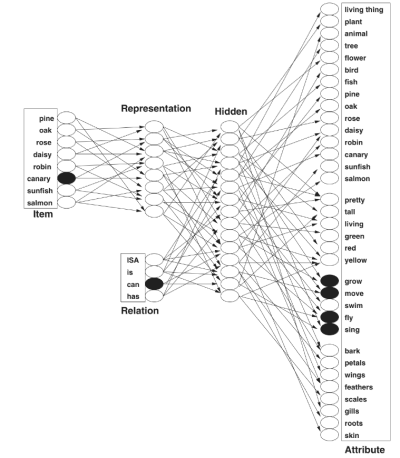

#### Getting the data

To train this model, we need to generate a list of all of the relevant input -> output mappings. Rogers & McClelland provide tables of the data in the back of their book, which I've converted to spreadsheets hosted on Google Drive.

### Quick aside: Hosting public data on Drive


This is a useful trick for future modeling work that you might do in Colab.

One of the downsides of Colab is that every time you start a new session and connect to a runtime, you are effectively starting from scratch. You can manually upload data to the server, but this is a pain. One simple solution for spreadsheet-style data is to put the data in Google Sheets and the publish it to the web.

In Google Sheets, you can select **File > Share > Publish to Web**

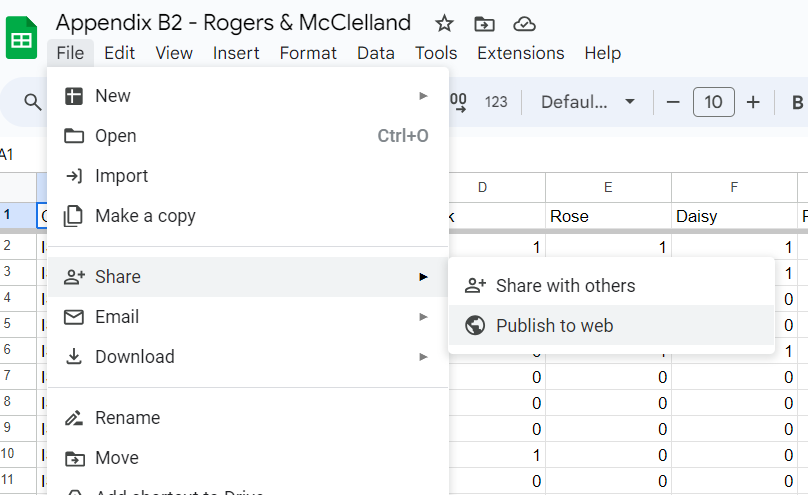

In the subsequent dialog, select the sheet that you want to publish and choose **CSV** as the format.

Once you publish it you'll get a link that you can use to load the data.

Pandas can load CSV data from a URL. Just use `pd.read_csv("https://path/to/my/data.csv")` and you can get your data.

Now you don't have to upload the data each time you start a Colab session. The script will automatically handle it for you.

### Appendix B2 data

Appendix B2 has the data for the models in chapter 3, which will be the focus of our lab.

Let's load the data and then take a look.

In [2]:
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vR_cXZ0Q0bVOCL6GpXAfcKP63ZWiFvYrjj4zfVmBYEef7YPJG0vyGypmZQdqrz_E0mvj08l_RhK5InL/pub?gid=0&single=true&output=csv")
data

,Relation,Attribute,Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon
0,ISA,LivingThing,1,1,1,1,1,1,1,1
1,ISA,Plant,1,1,1,1,0,0,0,0
2,ISA,Animal,0,0,0,0,1,1,1,1
3,ISA,Tree,1,1,0,0,0,0,0,0
4,ISA,Flower,0,0,1,1,0,0,0,0
5,ISA,Bird,0,0,0,0,1,1,0,0
6,ISA,Fish,0,0,0,0,0,0,1,1
7,ISA,Pine,1,0,0,0,0,0,0,0
8,ISA,Oak,0,1,0,0,0,0,0,0
9,ISA,Maple,0,0,0,0,0,0,0,0


Above, we can see that there are 8 different ITEMS organized into columns ("Pine", "Oak", "Rose", etc.).

The first column specifies a RELATION and the second column specifies an ATTRIBUTE.

If the ITEM has the ATTRIBUTE in a specific RELATION, then the table has a 1 in the appropriate cell. Otherwise, the table has a 0.

Relation-attribute pair counts: (total 37)\
ISA: 16\
IS: 6\
CAN: 5\
HAS: 10

### Converting this to training data

We need to use the table above to create input and output vectors for the model.

Each training example that the model sees will have two input vectors (ITEM and RELATION) and one output vector (ATTRIBUTES).

What we need to do is generate a set of these examples where we have all possible combinations of ITEM and RELATION and pair these with the appropriate ATTRIBUTES (total 37).



> Basically we have to go from RELATION + ATTRIBUTE -> ITEM\
> to ITEM + RELATION -> ATTRIBUTE



Let's start by extracting some important data from the table. We need:

- An array that contains each unique RELATION. We could build this manually, but let's learn something by grabbing it from the table instead.
- An array that contains each unique ITEM. Again, we could make this manually, but let's figure out how to get it from the table.

Once we have these, we can generate all the unique combinations.

The RELATIONS are in the `'Relation'` column of the data frame. To extract a column, we can use `data['columnName']`.

In [3]:
relation = data['Relation']
relation

0     ISA
1     ISA
2     ISA
3     ISA
4     ISA
5     ISA
6     ISA
7     ISA
8     ISA
9     ISA
10    ISA
11    ISA
12    ISA
13    ISA
14    ISA
15    ISA
16     IS
17     IS
18     IS
19     IS
20     IS
21     IS
22    CAN
23    CAN
24    CAN
25    CAN
26    CAN
27    HAS
28    HAS
29    HAS
30    HAS
31    HAS
32    HAS
33    HAS
34    HAS
35    HAS
36    HAS
37    HAS
Name: Relation, dtype: object

Now we need to figure out how to remove the duplicate entries and extract an array that contains only the four unique values. Use Google/ChatGPT/etc. to figure this out. Remember to specify that you are working with a pandas data frame, since the best solutions will be specific to that library.

In [4]:
relation_names = relation.drop_duplicates()
relation_names

0     ISA
16     IS
22    CAN
27    HAS
Name: Relation, dtype: object

The ITEM names are in the column names. We can use `data.columns` to get an array of the column names.

In [5]:
item = data.columns
item

Index(['Relation', 'Attribute', 'Pine', 'Oak', 'Rose', 'Daisy', 'Robin',
       'Canary', 'Sunfish', 'Salmon'],
      dtype='object')

How do we get just the 3rd column onward, dropping the first two? Again, use Google/ChatGPT/etc. to figure this out.

In [6]:
item_names = item[2:]
item_names

Index(['Pine', 'Oak', 'Rose', 'Daisy', 'Robin', 'Canary', 'Sunfish', 'Salmon'], dtype='object')

Now let's build the input data.

Each input is a pair of ITEM and RELATION. For training the model, we are going to want two separate arrays, one with all of the RELATION values and one with all of the ITEM values. If we line these arrays up together, we want there to be all unique combinations:

```
['Pine', 'Pine', 'Pine', 'Pine', 'Oak', 'Oak', ... ]
['ISA',  'IS',   'CAN',  'HAS',  'ISA', 'IS',  ... ]
```

> i.e. `8 (ITEMS) * 4 (RELATIONS) = 32` combinations


To achieve this we need to repeat each item in the `item_names` array once for each relation in the `relation_names` array, and repeat each relation once for each item. Importantly, for the items we should repeat in a way that keeps each instance of an item together (Pine, Pine, Pine, Pine, Oak, Oak, etc.) and for the relations we should cycle through the relations.

The two functions that will do this are `np.repeat()` and `np.tile()`. Look these up or experiment with them until you can achieve the target result.


In [7]:
x_items = np.repeat(item_names, len(relation_names))
x_items

Index(['Pine', 'Pine', 'Pine', 'Pine', 'Oak', 'Oak', 'Oak', 'Oak', 'Rose',
       'Rose', 'Rose', 'Rose', 'Daisy', 'Daisy', 'Daisy', 'Daisy', 'Robin',
       'Robin', 'Robin', 'Robin', 'Canary', 'Canary', 'Canary', 'Canary',
       'Sunfish', 'Sunfish', 'Sunfish', 'Sunfish', 'Salmon', 'Salmon',
       'Salmon', 'Salmon'],
      dtype='object')

In [8]:
x_relations = np.tile(relation_names, len(item_names))
x_relations

array(['ISA', 'IS', 'CAN', 'HAS', 'ISA', 'IS', 'CAN', 'HAS', 'ISA', 'IS',
       'CAN', 'HAS', 'ISA', 'IS', 'CAN', 'HAS', 'ISA', 'IS', 'CAN', 'HAS',
       'ISA', 'IS', 'CAN', 'HAS', 'ISA', 'IS', 'CAN', 'HAS', 'ISA', 'IS',
       'CAN', 'HAS'], dtype=object)

To get the list of attribute names, we can just grab the 'Attribute' column of the data.

In [9]:
attribute_names = data['Attribute']
attribute_names

0     LivingThing
1           Plant
2          Animal
3            Tree
4          Flower
5            Bird
6            Fish
7            Pine
8             Oak
9           Maple
10           Rose
11          Daisy
12          Robin
13         Canary
14        Sunfish
15         Salmon
16         Pretty
17            Big
18         Living
19          Green
20            Red
21         Yellow
22           Grow
23           Move
24           Swim
25            Fly
26           Sing
27           Skin
28          Roots
29         Leaves
30           Legs
31           Bark
32       Branches
33         Petals
34          Wings
35       Feathers
36         Scales
37          Gills
Name: Attribute, dtype: object

The shape of the output data is going to be (the number of training examples, the number of attributes).

This is because for each training example, we need a vector of attributes indicating a 0 or 1 for each attribute value.

> i.e. 32 * 37 matrix
> where each row is a output vector representing a ITEM-RELATION pair

Let's start by just creating an array of the appropriate shape, using the `np.zeros` function to create an array of 0s with a specified shape.

Use the variables you've created above and the `len()` function to do this.

In [10]:
y_attributes = np.zeros((len(x_items), len(attribute_names)))
y_attributes.shape

(32, 38)

Unfortunately, the data table in its current form doesn't really work. The biggest reason why is that we need *separate* outputs for each ITEM-RELATION combination. However, each column contains the information for all RELATIONS. So we can't just grab one of the columns to match the ITEM. Instead we need to grab the correct column and then set all of the attributes to 0 that are not part of the RELATION.

I've done this for you below, and commented the code so you can get a sense for what is happening.

In [11]:
for i in np.arange(len(x_items)): # 0 - 31
  item = x_items[i]
  relation = x_relations[i]
  item_attributes = data[item]

  # e.g. item we are currently looking at is 'Pine'
  # relation we are currently looking at is ISA
  # 0 out all the non-ISA rows in 'Pine' column in data that are not about ISA
  attributes_in_relation = item_attributes.where(data['Relation'] == relation, other=0)

  # y_attributes[i] = vector for certain ITEM-RELATION pair
  y_attributes[i] = attributes_in_relation

y_attributes.shape

(32, 38)

#### Building the network


In this section you're going to build the Keras implementation of the model yourself, but I'm going to try and give you a list of the critical features and point you to some useful building-blocks that we haven't encountered yet.

### Network features

These are details that I've been able to get from the book. Not all of these details are essential for reproducing the behavior of the model.

- The architecture of the model is shown above, at the top of the notebook.
- The representation layer has 8 units
- The hidden layer has 15 units
- All layers use a sigmoid activation function
- All weights are initialized using a random uniform distribution of values between -0.9 and 0.9.
- The loss function is the mean squared error.
- The optimizer is basic backprop (stochastic gradient descent) with a learning rate of 0.1. **However**: this doesn't seem to work well in the Keras implementation. I haven't been able to track down the cause yet. Using a different optimizer, like `RMSprop`, will work. You may need to adjust the learning rate to match the rate of change in activation patterns shown in the book.
- Weights are updated after every training example (i.e., `batch_size=1`).
- They assigned a fixed, untrainable bias of -2 to all output nodes. This is possible to do in Keras, but a bit tricky, so we are going to ignore this piece of the model.



### Some Keras tips


#### One-hot encoding our inputs

Our current inputs are bits of text like 'CAN' and 'HAS' for the RELATION input and 'Rose' and 'Oak' for the ITEM input. We need to encode these as one-hot (localist) representations. This means that we need 8 inputs for the ITEMs and 4 inputs for the RELATIONS.

We could do this as part of our data preprocessing. We could write some numpy-based code to transform the array of text into arrays of one-hot vectors. But this kind of transformation is a pretty common thing that models need to do when working with text-based input, so Keras has tools that can help us.

Specifically, Keras has a *layer* called `tf.keras.layers.StringLookup`. This layer can take a string as input and output a numeric representation that corresponds to the string's location in a vocabulary (i.e., a list of words). This converts a string to a number. The layer can also output in one-hot form, which is exactly what we need. It is a bit weird to think of a pre-processing step like this as a layer in the neural network, but Keras layers can be non-trainable data processing steps, which is really handy to quickly building models.


Here's an example of using `StringLookup`.

In [12]:
possible_inputs = ['a', 'b', 'c', 'd']

# create an Input layer that expects one input, with the data type of string
demo_input = tf.keras.layers.Input(1, dtype="string")
# create a StringLookup layer that outputs a one_hot representation
demo_one_hot = tf.keras.layers.StringLookup(vocabulary=possible_inputs, output_mode="one_hot")(demo_input)

# create the Keras model
demo_model = tf.keras.Model(inputs=demo_input, outputs=demo_one_hot)

# print out the model summary
demo_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 string_lookup (StringLooku  (None, 5)                 0         
 p)                                                              
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Notice that the above model has 0 trainable parameters, which makes sense because we are just doing a deterministic conversion from a string to a one hot represenation.

Notice also that the shape of the string lookup layer is `(None, 5)`. Why is this outputting 5 units when our vocabulary has only 4 items?

The reason is that the default configuration for this layer is to include one extra output that is turned on anytime it receives an input that is not in the vocabulary list. (This is used frequently in language modeling, where very rare words or non-words might not be encoded in the network architecture.) However, for our purposes we don't want this extra out-of-vocabulary option, so we can set `num_oov_indices=0` in the `StringLookup` layer to remove it.

#### Merging two paths in the network

The Semantic Cognition model has two separate input paths that merge together at the hidden layer. How do we do this in Keras?

There are two parts to this.

**First, how do we pass in two distinct inputs?** This is pretty straightforward. Create two seperate `tf.keras.layers.Input` layers. When you use `tf.keras.Model(inputs=[...], outputs=[...])` just list both input layers in the `inputs` list.

Then, when you run `model.fit()` to train the model, pass in a list for your `x` values, e.g., `model.fit(x=[x_input_1, x_input_2],...)`. Make sure that the order that you list the input layers in `tf.keras.Model()` matches the order that you pass in `model.fit()`

**Second, how do we merge together two paths at the hidden layer?** Keras has a set of layers that are designed for different kinds of merges. We're going to use the `tf.keras.layers.Concatenate()` layer, which simply takes two or more layers and produces an output that is the combination of all layers. Here's an example:

In [13]:
demo_a = tf.keras.layers.Input(10)
demo_b = tf.keras.layers.Input(7)
demo_merge = tf.keras.layers.Concatenate()([demo_a, demo_b])

demo_merge_model = tf.keras.Model(inputs=[demo_a, demo_b], outputs=demo_merge)

demo_merge_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 17)                   0         ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 By

Notice that the output of the concatenate layer has shape `(None, 17)`, which is just combining the two inputs into a single layer.

Notice, too, that there are 0 trainable parameters in this model, as `Concatenate` doesn't have any weights.

#### Initializing a layer with specific weights

The Semantic Cognition model's weights are initially set a random values between -0.9 and 0.9, with a uniform distribution. This isn't the default pattern of weight initialization for Keras layers, so we need to specify this.

The relevant argument is `kernel_initializer=`, which is an argument that can be passed to most of the layers with trainable parameters. Kernel is just another name for weights, but is more commonly used in the computer science and math world.

There are a lot of `initializer` functions that Keras provides, and you can find them on the Keras website under [initializers](https://keras.io/api/layers/initializers/).

Use the website documentation to figure out how to initialize the weights to random uniformly distributed values between -0.9 and 0.9.

### Constructing the model

You've got all the pieces to build the model now! Go for it. Include the `.compile()` step and print out the `.summary()` of the model. Don't train the model yet.

In [14]:
# create a bunch of layers
input_layer = tf.keras.layers.Input(shape=1, name="Item_Input", dtype="string") # 1 ITEM
relation_layer = tf.keras.layers.Input(shape=1, name="Relation_Input", dtype="string") # 1 RELATION

one_hot_items = tf.keras.layers.StringLookup(vocabulary=item_names, output_mode="one_hot", num_oov_indices=0, name="Item_OneHot")(input_layer)
one_hot_relations = tf.keras.layers.StringLookup(vocabulary=relation_names, output_mode="one_hot", num_oov_indices=0, name="Relation_OneHot")(relation_layer)

representation_layer = tf.keras.layers.Dense(8, activation="sigmoid", kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9), name="Item_Representation")(one_hot_items)

merge_input = tf.keras.layers.Concatenate(name="Item_Relation_Concatenate")([representation_layer, one_hot_relations])
hidden_layer = tf.keras.layers.Dense(15, activation="sigmoid", name="Hidden")(merge_input)

output_layer = tf.keras.layers.Dense(len(attribute_names), activation="sigmoid", name="Output")(hidden_layer)

# build a model
semantic_model = tf.keras.Model(inputs=[input_layer, relation_layer], outputs=[output_layer], name="Semantic_Model")

# compile the model
semantic_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.002),
    loss="mean_squared_error",
)

# print the model summary
semantic_model.summary()

Model: "Semantic_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Item_OneHot (StringLookup)  (None, 8)                    0         ['Item_Input[0][0]']          
                                                                                                  
 Relation_Input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 Item_Representation (Dense  (None, 8)                    72        ['Item_OneHot[0][

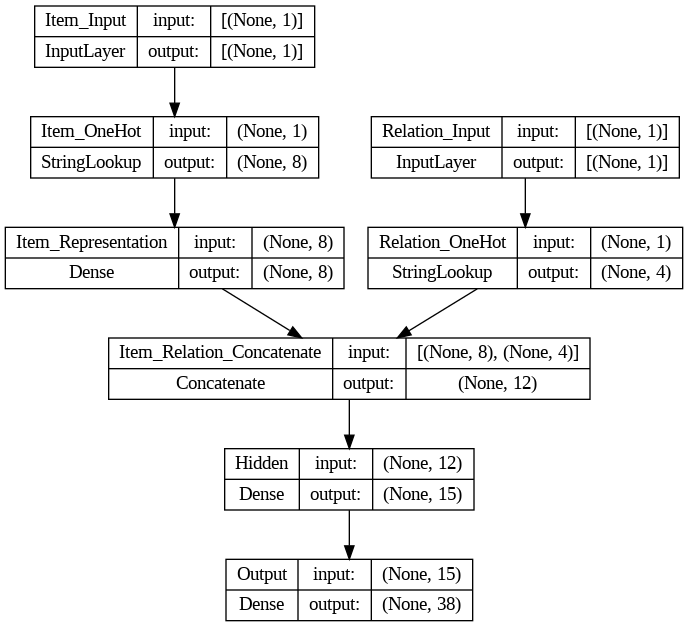

In [15]:
# plot the model
tf.keras.utils.plot_model(
    semantic_model,
    to_file="semantic_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

### Constructing the sub-model



Rogers & McClelland are mostly interested in analyzing the behavior of the model and not *whether* the model can learn the patterns. To analyze the behavior, they often record the activation patterns of different layers during training. There are many ways to do this using Keras. I've chosen a method to share that I think is (a) relatively easy to implement and (b) useful in a variety of contexts. The downside of my approach is that it is a bit less automated than some of the more sophisticated ways of handling this.

The key idea is that once you create a `Layer` object using Keras, you can use that same layer in more than one model, and any training you've done on the layer's weights will apply to all the models that the layer is used in.

This means that we can build a new model that is just the ITEM input and the representation layer if what we are interested in is the activity of the representation layer to different items.

To do this, create a new `tf.keras.Model()` and set the `inputs` to whatever you called your input layer for the item and the `outputs` to whatever you called the `Dense` layer that is the representation layer in the model.

Print the `summary()` of the model. It should have three layers (Input, StringLookup, Dense) and 72 parameters.

Even though this model is trainable, we aren't going to train it. We're just going to use the `predict()` function to measure the output in response to different inputs.

In [16]:
item_representation_model = tf.keras.Model(inputs=[input_layer], outputs=[representation_layer], name="Item_Representation_Model")

item_representation_model.summary()

Model: "Item_Representation_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Item_Input (InputLayer)     [(None, 1)]               0         
                                                                 
 Item_OneHot (StringLookup)  (None, 8)                 0         
                                                                 
 Item_Representation (Dense  (None, 8)                 72        
 )                                                               
                                                                 
Total params: 72 (288.00 Byte)
Trainable params: 72 (288.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model

Model 3.1 in the book involves training the model for 50 epochs at a time and observing how the similarity of representations at the representation layer changes over each set of 50 epochs.

Use `.fit()` to train the model for 50 epochs.

Then use `.predict()` with the sub-model (representation layer only) and pass in the list of unique items. This will give us one output for each item. Save this set of predictions in a variable, e.g., `representations_50` for the representations after 50 epochs.

Then repeat the process two more times, but save the predictions in two different variables like `representations_100` and `representations_150`.

### Representations after 50 epochs

In [17]:
semantic_model.fit(
    x=[x_items, x_relations],
    y=y_attributes,
    batch_size=1,
    epochs=50
)

Epoch 1/50
32/32 [==============================] - 1s 6ms/step - loss: 0.1968
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.1296
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0946
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0788
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0726
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0704
Epoch 7/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0695
Epoch 8/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0691
Epoch 9/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0689
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0688
Epoch 11/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0686
Epoch 12/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0685
Epoch 13/50
32/32 [===========================

In [18]:
representations_50 = item_representation_model.predict(item_names)

1/1 [==============================] - 0s 314ms/step


> Oh so when you fit (train) semantic_model, the representation layer weights in it update, and this is shared across all sub-models that also have that layer, i.e. you don't have to make the item_representation_model again - the weights of the layers in it are automatically updated.

### Representations after 100 epochs

In [19]:
semantic_model.fit(
    x=[x_items, x_relations],
    y=y_attributes,
    batch_size=1,
    epochs=50
)
representations_100 = item_representation_model.predict(item_names)

Epoch 1/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0552
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0548
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0544
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0540
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0536
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0532
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0528
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0524
Epoch 9/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0520
Epoch 10/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0517
Epoch 11/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0513
Epoch 12/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0510
Epoch 13/50
32/32 [==============================

1/1 [==============================] - 0s 41ms/step


### Representations after 150 epochs

In [20]:
semantic_model.fit(
    x=[x_items, x_relations],
    y=y_attributes,
    batch_size=1,
    epochs=50
)
representations_150 = item_representation_model.predict(item_names)

Epoch 1/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0441
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0441
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0439
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0437
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0436
Epoch 9/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0436
Epoch 10/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0435
Epoch 11/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0435
Epoch 12/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0434
Epoch 13/50
32/32 [==============================

1/1 [==============================] - 0s 35ms/step


#### Visualizing the results

At this point you should have three variables, and each should have shape `(8,8)`, for 8 unique items and 8 activation values from the representation layer.

We're going to do some data wrangling here to organize these values into one data frame so that we can make a plot that looks like this one from the book:

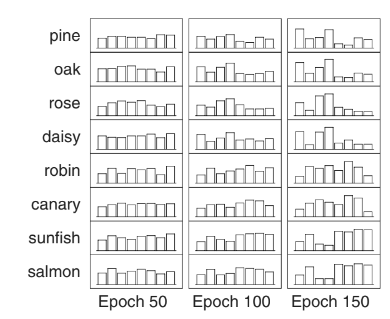

Our goal is to make a dataframe with this sort of structure:

item | epoch | feature | value
-----| ----- | ------- | -----
pine | 50 | 0 | 0.723
pine | 50 | 1 | 0.235
pine | 50 | 2 | 0.723
pine | 50 | 3 | 0.235
pine | 50 | 4 | 0.723
pine | 50 | 5 | 0.235
pine | 50 | 6 | 0.723
pine | 50 | 7 | 0.235
pine | 100 | 0 | 0.723
pine | 100 | 1 | 0.235
pine | 100 | 2 | 0.723
pine | 100 | 3 | 0.235
pine | 100 | 4 | 0.723
pine | 100 | 5 | 0.235
pine | 100 | 6 | 0.723
pine | 100 | 7 | 0.235

... but with all 8 items and the 150 epoch measurement too.

To do this, we can convert each of the 3 variables you recorded into a data frame with the right structure, and then use `pd.concatenate()` to merge them all together.

I'm going to assume that the data with the representations after 50 epochs of training is called `representations_50`. If not, adjust the code below to follow along.

First, we can use `pd.DataFrame()` to convert the `(8,8)` array to a data frame.

In [21]:
df_representations_50 = pd.DataFrame(representations_50)

Let's see what this looks like:

In [22]:
df_representations_50

,0,1,2,3,4,5,6,7
0,0.705051,0.581000,0.716685,0.523905,0.653080,0.664325,0.418471,0.706011
1,0.538366,0.680667,0.452399,0.366371,0.425252,0.493564,0.524888,0.345726
2,0.510318,0.345096,0.359448,0.506982,0.425383,0.561577,0.459845,0.669549
3,0.691408,0.580872,0.330955,0.355477,0.613214,0.563455,0.445286,0.316017
4,0.385713,0.509612,0.645822,0.300690,0.286289,0.671521,0.437159,0.498805
5,0.421198,0.565221,0.448838,0.636228,0.471017,0.596778,0.457493,0.658071
6,0.524146,0.556795,0.673257,0.427271,0.567702,0.627655,0.412472,0.696400
7,0.497722,0.586674,0.648097,0.375807,0.566768,0.307312,0.595699,0.519511


Basically, just a matrix at this point. Each row is an item, and each column is one of the features. Let's add a column with the names of the items.

In [23]:
df_representations_50['label'] = item_names

In [24]:
df_representations_50

,0,1,2,3,4,5,6,7,label
0,0.705051,0.581000,0.716685,0.523905,0.653080,0.664325,0.418471,0.706011,Pine
1,0.538366,0.680667,0.452399,0.366371,0.425252,0.493564,0.524888,0.345726,Oak
2,0.510318,0.345096,0.359448,0.506982,0.425383,0.561577,0.459845,0.669549,Rose
3,0.691408,0.580872,0.330955,0.355477,0.613214,0.563455,0.445286,0.316017,Daisy
4,0.385713,0.509612,0.645822,0.300690,0.286289,0.671521,0.437159,0.498805,Robin
5,0.421198,0.565221,0.448838,0.636228,0.471017,0.596778,0.457493,0.658071,Canary
6,0.524146,0.556795,0.673257,0.427271,0.567702,0.627655,0.412472,0.696400,Sunfish
7,0.497722,0.586674,0.648097,0.375807,0.566768,0.307312,0.595699,0.519511,Salmon


Now we've got a clearer idea of which row is which. Let's also add a column with how many epochs the model has been trained. This will be important when we merge this data with the other data later.

In [25]:
df_representations_50['epoch'] = 50

In [26]:
df_representations_50

,0,1,2,3,4,5,6,7,label,epoch
0,0.705051,0.581000,0.716685,0.523905,0.653080,0.664325,0.418471,0.706011,Pine,50
1,0.538366,0.680667,0.452399,0.366371,0.425252,0.493564,0.524888,0.345726,Oak,50
2,0.510318,0.345096,0.359448,0.506982,0.425383,0.561577,0.459845,0.669549,Rose,50
3,0.691408,0.580872,0.330955,0.355477,0.613214,0.563455,0.445286,0.316017,Daisy,50
4,0.385713,0.509612,0.645822,0.300690,0.286289,0.671521,0.437159,0.498805,Robin,50
5,0.421198,0.565221,0.448838,0.636228,0.471017,0.596778,0.457493,0.658071,Canary,50
6,0.524146,0.556795,0.673257,0.427271,0.567702,0.627655,0.412472,0.696400,Sunfish,50
7,0.497722,0.586674,0.648097,0.375807,0.566768,0.307312,0.595699,0.519511,Salmon,50


Finally, we need to take all of those columns and pivot them into rows. This step is a bit unusual if you haven't done this kind of data manipulation before. If you have some experience with R and the tidyverse, this is the pandas equivalent of `tidyr::pivot_longer`.

In [27]:
df_representations_50 = pd.melt(df_representations_50, id_vars = ['label', 'epoch'], var_name="feature", value_name="value")

In [28]:
df_representations_50

,label,epoch,feature,value
0,Pine,50,0,0.705051
1,Oak,50,0,0.538366
2,Rose,50,0,0.510318
3,Daisy,50,0,0.691408
4,Robin,50,0,0.385713
...,...,...,...,...
59,Daisy,50,7,0.316017
60,Robin,50,7,0.498805
61,Canary,50,7,0.658071
62,Sunfish,50,7,0.696400


Basically, we took all of the columns that weren't in the `id_vars` list and put the column name in `feature` and the corresponding value in `value`. So instead of an 8 x 10 dataframe we have a 64 x 4 data frame.

Repeat the steps above for the 100 and 150 epoch data.

In [29]:
# copy some code to do some stuff
df_representations_100 = pd.DataFrame(representations_100)
df_representations_100['label'] = item_names
df_representations_100['epoch'] = 100
df_representations_100 = pd.melt(df_representations_100, id_vars = ['label', 'epoch'], var_name="feature", value_name="value")
df_representations_100

,label,epoch,feature,value
0,Pine,100,0,0.722995
1,Oak,100,0,0.575698
2,Rose,100,0,0.524182
3,Daisy,100,0,0.707910
4,Robin,100,0,0.402846
...,...,...,...,...
59,Daisy,100,7,0.314951
60,Robin,100,7,0.492992
61,Canary,100,7,0.643062
62,Sunfish,100,7,0.688309


In [30]:
# copy more code to do more stuff
df_representations_150 = pd.DataFrame(representations_150)
df_representations_150['label'] = item_names
df_representations_150['epoch'] = 150
df_representations_150 = pd.melt(df_representations_150, id_vars = ['label', 'epoch'], var_name="feature", value_name="value")
df_representations_150

,label,epoch,feature,value
0,Pine,150,0,0.744934
1,Oak,150,0,0.629001
2,Rose,150,0,0.551240
3,Daisy,150,0,0.734416
4,Robin,150,0,0.408735
...,...,...,...,...
59,Daisy,150,7,0.312743
60,Robin,150,7,0.497219
61,Canary,150,7,0.648274
62,Sunfish,150,7,0.696661


Now combine all 3 data frames together, using `df_representations = pd.concat([df1, df2, df3])`, replacing the `df1` etc. with the correct names.

In [31]:
df_representations = pd.concat([df_representations_50, df_representations_100, df_representations_150])

To visualize the data, we can again use `ggplot`.

The basic structure of the graph is to put `feature` on the x-axis and `value` on the y-axis. The datapoints are visualized using columns via `geom_col()`. To generate separate plots for each combination of `epoch` and `item`, we use faceting.

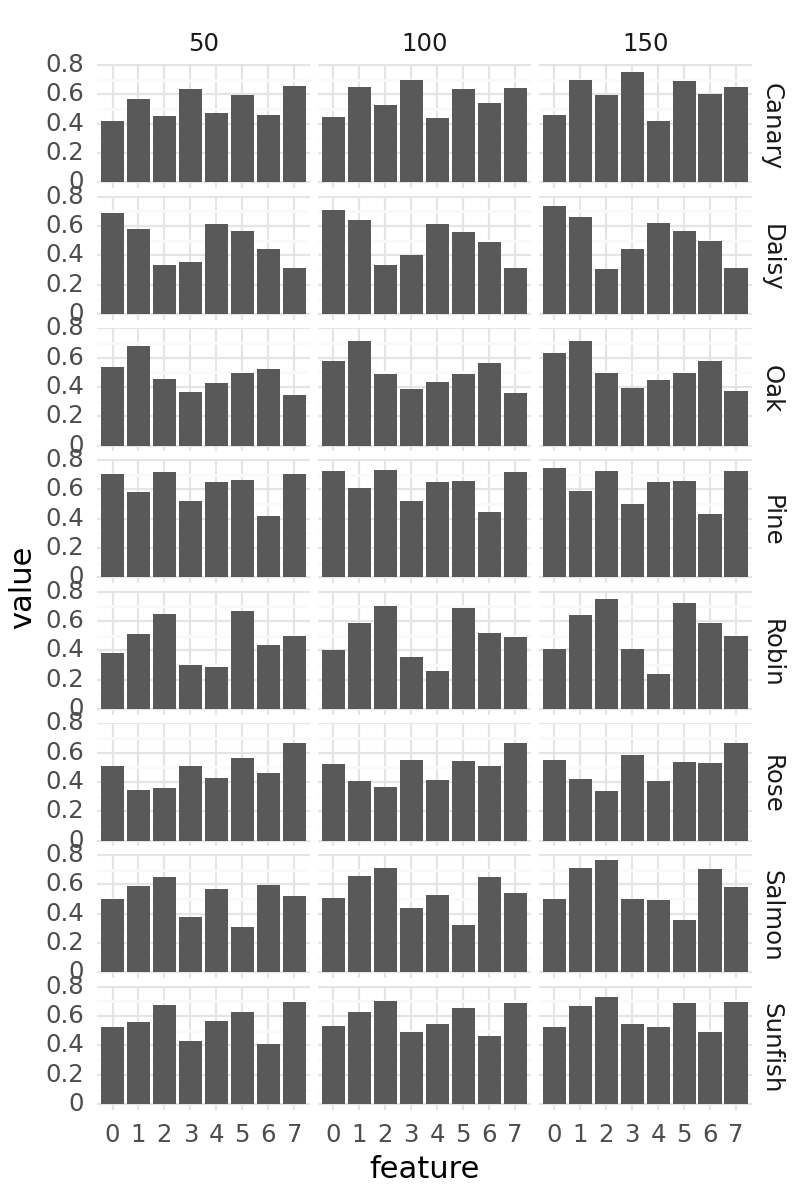

<Figure Size: (400 x 600)>

In [32]:
from plotnine import ggplot, geom_col, aes, facet_grid, theme_minimal, theme

(ggplot(df_representations, aes(x="feature", y="value")) +
 geom_col() +
 facet_grid("label~epoch")+
 theme_minimal() +
 theme(figure_size=(4,6))
)

For the dendograms, which visualize the similarity between vectors. We can use a feature from the `scipy` library. We're going to import the `linkage` and `dendrogram` functions from `scipy.cluster.hierarchy`.

`linkage()` will take a matrix of data (e.g., `representations_50`) and calculate the pair-wise similarity for all combinations of rows, using this to then find a hierarchical clustering of the data.

`dendrogram()` then visualizes the cluster relationships.

We'll plot each of the three dendograms separately to show how the clustering relationships shift over time.

In [33]:
from scipy.cluster.hierarchy import linkage, dendrogram

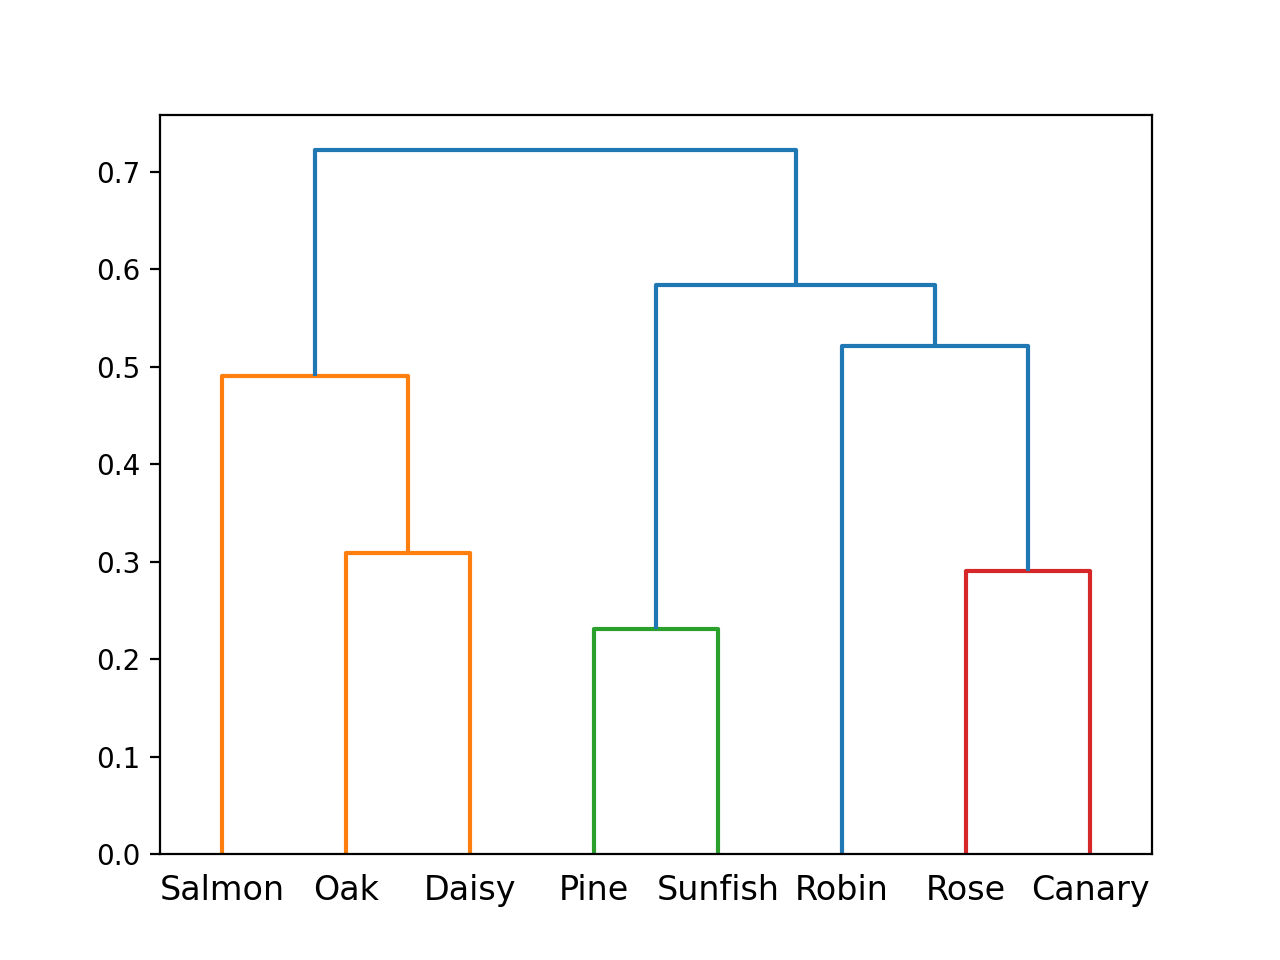

In [34]:
cluster_plot_50 = dendrogram(linkage(representations_50, method="ward"), labels=item_names)

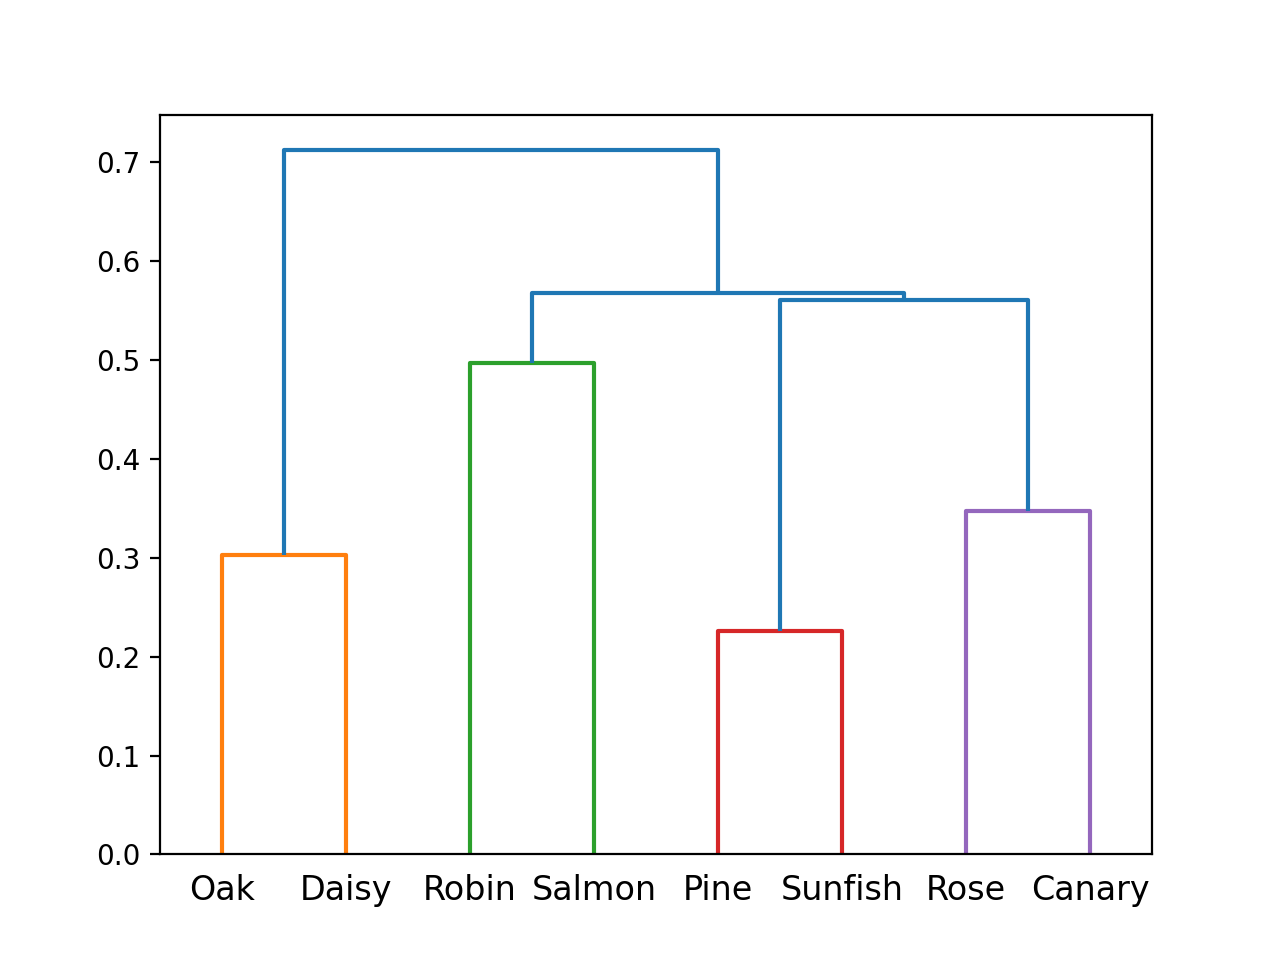

In [35]:
cluster_plot_100 = dendrogram(linkage(representations_100, method="ward"), labels=item_names)

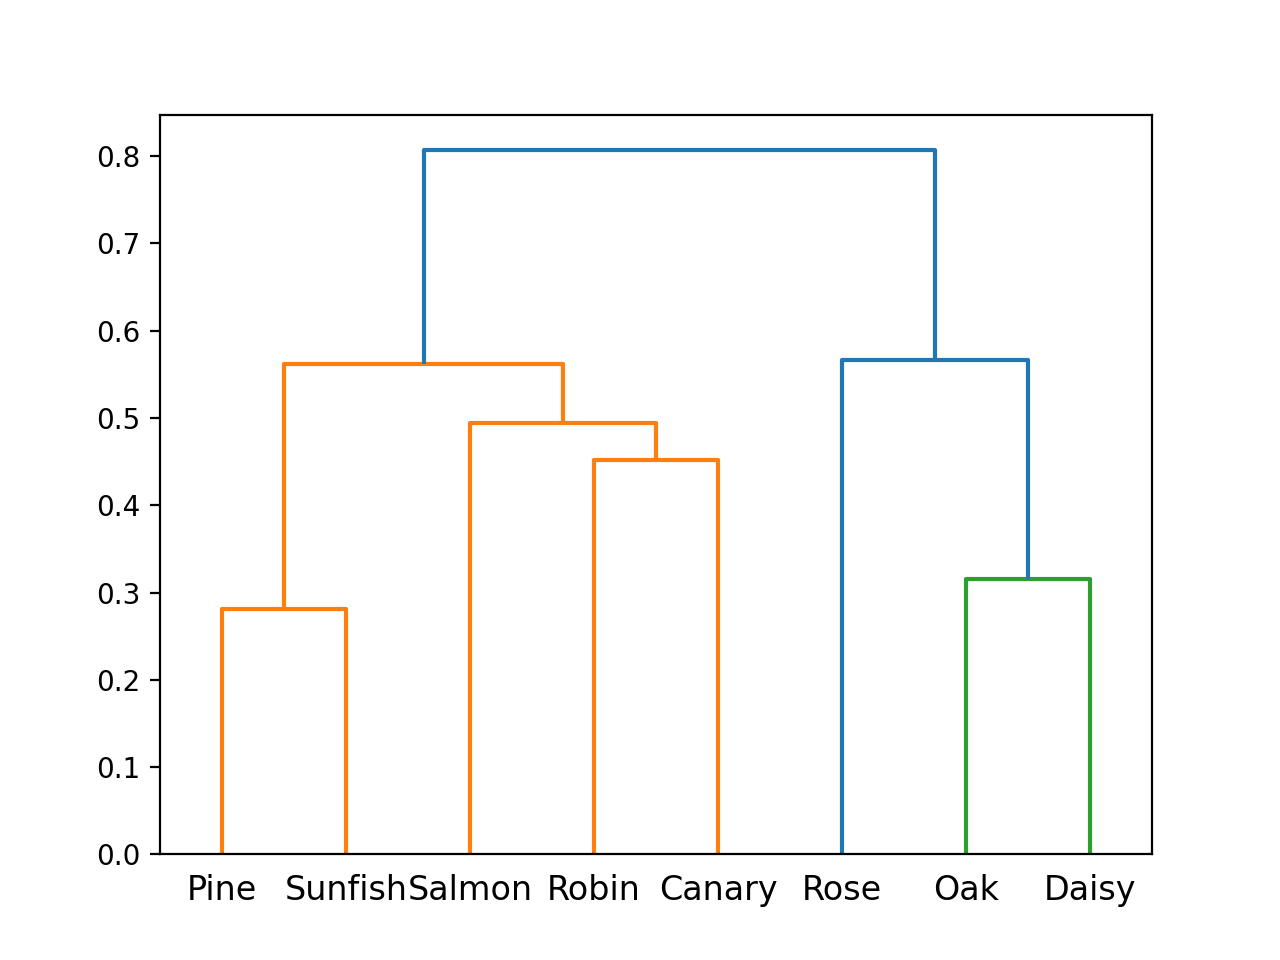

In [36]:
cluster_plot_150 = dendrogram(linkage(representations_150, method="ward"), labels=item_names)

## Part 2: [Simulation 5.4] Effects of Familiarity on Naming in Development and Dementia

Now that you've worked through the implementation of the model and some basic data visualization, pick an experiment from Chapter 5 of the book and implement it. Include as much of the analysis as you can from the experiment, which might require you to learn some additional analysis techniques. I encourage you to consult each other, Google, and AI tools for help with figuring out how to do this. Oh, and me, of course.

The dataset from Appendix B3, which you will probably need, is available here:

https://docs.google.com/spreadsheets/d/e/2PACX-1vRdgO8XhgSobD_-tRwJvqdzog9WuxebpS-MyF1hydYGHGNmDAhngnn3nR4ObsuQiB95FVFNEXypH-dD/pub?gid=0&single=true&output=csv

### Effects of Familiarity: Simulating Over-extension of Familiar Basic Names in Development

#### Extracting data from Appendix B3

In [37]:
from plotnine import geom_line, geom_point, geom_text, element_text, labs, facet_wrap

In [38]:
appendix_data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSSqgvv3GTpCz0VRRAQ5dymhAdh1RCT02KJ95K73HQmUBh-F_4h-dIz2HbvlGG-g30Derq7VLmECDa_/pub?gid=0&single=true&output=csv")
appendix_data

,Relation,Attribute,Pine,Oak,Maple,Birch,Rose,Daisy,Tulip,Sunflower,...,Penguin,Sunfish,Salmon,Flounder,Cod,Cat,Dog,Mouse,Goat,Pig
0,ISA-GENERAL,Plant,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,ISA-GENERAL,Animal,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,ISA-BASIC,Tree,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ISA-BASIC,Flower,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,ISA-BASIC,Bird,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,ISA-BASIC,Fish,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
6,ISA-BASIC,Cat,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,ISA-BASIC,Dog,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,ISA-BASIC,Mouse,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,ISA-BASIC,Goat,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Creating input dataframe structure

In [39]:
appendix_item_names = appendix_data.columns[2:]
appendix_item_names = appendix_item_names[appendix_item_names != 'Dog'].tolist() + ['Dog']
appendix_item_names

['Pine',
 'Oak',
 'Maple',
 'Birch',
 'Rose',
 'Daisy',
 'Tulip',
 'Sunflower',
 'Robin',
 'Canary',
 'Sparrow',
 'Penguin',
 'Sunfish',
 'Salmon',
 'Flounder',
 'Cod',
 'Cat',
 'Mouse',
 'Goat',
 'Pig',
 'Dog']

> 26 ITEMS

In [40]:
appendix_relation_names = appendix_data['Relation'].drop_duplicates()
appendix_relation_names

0      ISA-GENERAL
2        ISA-BASIC
11    ISA-SPECIFIC
27              IS
35             CAN
41             HAS
Name: Relation, dtype: object

> 6 RELATIONS

In [41]:
appendix_attributes = appendix_data['Attribute'].values
appendix_attributes

array(['Plant', 'Animal', 'Tree', 'Flower', 'Bird', 'Fish', 'Cat', 'Dog',
       'Mouse', 'Goat', 'Pig', 'Pine', 'Oak', 'Maple', 'Birch', 'Rose',
       'Daisy', 'Tulip', 'Sunflower', 'Robin', 'Canary', 'Sparrow',
       'Penguin', 'Sunfish', 'Salmon', 'Flounder', 'Cod', 'Pretty', 'Big',
       'Living', 'Green', 'Red', 'Yellow', 'White', 'Twirly', 'Grow',
       'Move', 'Swim', 'Fly', 'Walk', 'Sing', 'Leaves', 'Roots', 'Skin',
       'Legs', 'Bark', 'Branches', 'Petals', 'Wings', 'Feathers',
       'Scales', 'Gills', 'Fur'], dtype=object)

> 53 ATTRIBUTES

In [42]:
appendix_x_items = np.repeat(appendix_item_names, len(appendix_relation_names))
appendix_x_items

array(['Pine', 'Pine', 'Pine', 'Pine', 'Pine', 'Pine', 'Oak', 'Oak',
       'Oak', 'Oak', 'Oak', 'Oak', 'Maple', 'Maple', 'Maple', 'Maple',
       'Maple', 'Maple', 'Birch', 'Birch', 'Birch', 'Birch', 'Birch',
       'Birch', 'Rose', 'Rose', 'Rose', 'Rose', 'Rose', 'Rose', 'Daisy',
       'Daisy', 'Daisy', 'Daisy', 'Daisy', 'Daisy', 'Tulip', 'Tulip',
       'Tulip', 'Tulip', 'Tulip', 'Tulip', 'Sunflower', 'Sunflower',
       'Sunflower', 'Sunflower', 'Sunflower', 'Sunflower', 'Robin',
       'Robin', 'Robin', 'Robin', 'Robin', 'Robin', 'Canary', 'Canary',
       'Canary', 'Canary', 'Canary', 'Canary', 'Sparrow', 'Sparrow',
       'Sparrow', 'Sparrow', 'Sparrow', 'Sparrow', 'Penguin', 'Penguin',
       'Penguin', 'Penguin', 'Penguin', 'Penguin', 'Sunfish', 'Sunfish',
       'Sunfish', 'Sunfish', 'Sunfish', 'Sunfish', 'Salmon', 'Salmon',
       'Salmon', 'Salmon', 'Salmon', 'Salmon', 'Flounder', 'Flounder',
       'Flounder', 'Flounder', 'Flounder', 'Flounder', 'Cod', 'Cod',
       'Cod'

In [43]:
appendix_x_relations = np.tile(appendix_relation_names, len(appendix_item_names))
appendix_x_relations

array(['ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
       'ISA-GENERAL', 'ISA-BASIC', 'ISA-SPECIFIC', 'IS', 'CAN', 'HAS',
      

> `21 (ITEMS) * 6 (RELATIONS) = 126` ITEM-RELATION pairs

In [44]:
appendix_frequency_dog1x = [
    [40.00, 30.00, 5.000, 167.0, 167.0, 167.0],
    [40.00, 30.00, 5.000, 167.0, 167.0, 167.0],
    [40.00, 30.00, 3.000, 111.0, 111.0, 111.0],
    [40.00, 30.00, 3.000, 111.0, 111.0, 111.0],
    [40.00, 120.0, 3.000, 90.00, 90.00, 90.00]
]

appendix_frequency_dog1x_full = np.concatenate([
    np.tile(appendix_frequency_dog1x[0], 4),
    np.tile(appendix_frequency_dog1x[1], 4),
    np.tile(appendix_frequency_dog1x[2], 4),
    np.tile(appendix_frequency_dog1x[3], 4),
    np.tile(appendix_frequency_dog1x[4], 5)
])

len(appendix_frequency_dog1x_full)

126

These should be 'equivalent':
> Frequency of bird + fish = `3248`\
> Frequency of mammals = `2165`

And these:
> Frequency of plants = `4608`\
> Frequency of animals = `5413`

In [45]:
appendix_frequency_dog8x = [
    [25.60, 19.20, 3.210, 167.0, 167.0, 167.0],   # pine, oak, maple, birch
    [25.60, 19.20, 3.210, 167.0, 167.0, 167.0],   # rose, diasy, tulip, sunflower
    [25.60, 19.20, 1.280, 111.0, 111.0, 111.0],   # robin, canary, sparrow, penguin
    [25.60, 19.20, 1.280, 111.0, 111.0, 111.0],   # sunfish, salmon, flounder, cod
    [25.60, 76.90, 1.280, 37.00, 37.00, 37.00],   # cat, mouse, goat, pig
    [205.0, 615.0, 10.30, 296.0, 296.0, 296.0]    # dog
]

appendix_frequency_dog8x_full = np.concatenate([
    np.tile(appendix_frequency_dog8x[0], 4),
    np.tile(appendix_frequency_dog8x[1], 4),
    np.tile(appendix_frequency_dog8x[2], 4),
    np.tile(appendix_frequency_dog8x[3], 4),
    np.tile(appendix_frequency_dog8x[4], 4),
    appendix_frequency_dog8x[5]
])

len(appendix_frequency_dog8x_full)

126

These should be 'equivalent':
> Frequency of bird + fish = `3032.64`\
> Frequency of mammals = `2577.42`

And these:
> Frequency of plants = `4392`\
> Frequency of animals = `5610`

In [46]:
appendix_frequency_dog16x = [
    [18.20, 13.60, 2.270, 167.0, 167.0, 167.0],
    [18.20, 13.60, 2.270, 167.0, 167.0, 167.0],
    [18.20, 13.60, 0.649, 111.0, 111.0, 111.0],
    [18.20, 13.60, 0.649, 111.0, 111.0, 111.0],
    [18.20, 54.50, 0.649, 22.20, 22.20, 22.20],
    [291.0, 873.0, 10.40, 355.0, 355.0, 355.0]
]

appendix_frequency_dog16x_full = np.concatenate([
    np.tile(appendix_frequency_dog16x[0], 4),
    np.tile(appendix_frequency_dog16x[1], 4),
    np.tile(appendix_frequency_dog16x[2], 4),
    np.tile(appendix_frequency_dog16x[3], 4),
    np.tile(appendix_frequency_dog16x[4], 4),
    appendix_frequency_dog16x[5]
])

len(appendix_frequency_dog16x_full)

126

These should be 'equivalent':
> Frequency of bird + fish = `2924`\
> Frequency of mammals = `2799`

And these:
> Frequency of plants = `4281`\
> Frequency of mammals = `5723`

In [47]:
appendix_full_table_1x = pd.DataFrame({
    "Item": appendix_x_items,
    "Relation": appendix_x_relations,
    "Frequency": appendix_frequency_dog1x_full,
})

In [48]:
appendix_full_table_8x = pd.DataFrame({
    "Item": appendix_x_items,
    "Relation": appendix_x_relations,
    "Frequency": appendix_frequency_dog8x_full
})

In [49]:
appendix_full_table_16x = pd.DataFrame({
    "Item": appendix_x_items,
    "Relation": appendix_x_relations,
    "Frequency": appendix_frequency_dog16x_full
})

> These tables convert frequency to probability values (0 to 1) by dividing each frequency value by the sum of all frequency values across the table

In [50]:
appendix_full_table_1x['Probability'] = appendix_full_table_1x['Frequency'] / np.sum(appendix_full_table_1x['Frequency'])

In [51]:
appendix_full_table_8x['Probability'] = appendix_full_table_8x['Frequency'] / np.sum(appendix_full_table_8x['Frequency'])
appendix_full_table_8x

,Item,Relation,Frequency,Probability
0,Pine,ISA-GENERAL,25.60,0.002559
1,Pine,ISA-BASIC,19.20,0.001920
2,Pine,ISA-SPECIFIC,3.21,0.000321
3,Pine,IS,167.00,0.016696
4,Pine,CAN,167.00,0.016696
...,...,...,...,...
121,Dog,ISA-BASIC,615.00,0.061487
122,Dog,ISA-SPECIFIC,10.30,0.001030
123,Dog,IS,296.00,0.029594
124,Dog,CAN,296.00,0.029594


In [52]:
appendix_full_table_16x['Probability'] = appendix_full_table_16x['Frequency'] / np.sum(appendix_full_table_16x['Frequency'])

#### Constructing the Model

![semantic_cognition_extended_model.png](attachment:28e6d72d-a257-42b5-9793-05343b6f8123.png)

> **Appendix Model properties:**
> 1. 15 units in representation layer
> 2. 28 units in hidden layer
> 3. Weights initialized to values from uniform distribution centered at 0, range of -0.9 to 0.9
> 4. Learning rate = 0.005
> 5. No weight decay or momentum
> 6. Bias weights for all output units fixed at -2
> 7. Model encounters every training pattern once per epoch in random order
> 8. Small amount of noise in all hidden units throughout training: Gaussian distribution centered at 0, variance of 0.05
> 9. Soft targets used for training patterns -> active attributes in y_attributes set to 0.95; inactive set to 0.05
> 10. Weights updated every 10 pattern presentations
> 11. Sample each pattern randomly 1000 times per epoch
> 12. Train for 12,000 epochs

In [53]:
# Layers
sim_development_item_input_layer = tf.keras.layers.Input(1, name="Item_Input", dtype="string")
sim_development_relation_input_layer = tf.keras.layers.Input(1, name="Relation_Input", dtype="string")

sim_development_item_onehot_layer = tf.keras.layers.StringLookup(name="Item_OneHot", vocabulary=appendix_item_names, num_oov_indices=0, output_mode="one_hot")(sim_development_item_input_layer)
sim_development_relation_onehot_layer = tf.keras.layers.StringLookup(name="Relation_OneHot", vocabulary=appendix_relation_names, num_oov_indices=0, output_mode="one_hot")(sim_development_relation_input_layer)

# representation layer: 15 units
# weights initialized to values from uniform distribution centered at 0, range of -0.9 to 0.9
sim_development_representation_layer = tf.keras.layers.Dense(15, activation="sigmoid", name="Representation", kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9))(sim_development_item_onehot_layer)

sim_development_merge_input_layer = tf.keras.layers.Concatenate(name="Merge")([sim_development_representation_layer, sim_development_relation_onehot_layer])

# hidden layer: 28 units
# same -0.9 to 0.9 weight distribution
sim_development_hidden_layer = tf.keras.layers.Dense(28, activation="sigmoid",  kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9), name="Hidden")(sim_development_merge_input_layer)

# 0.05 variance Gaussian noise
sim_development_noise_layer = tf.keras.layers.GaussianNoise(0.05, name="Hidden_Noise")(sim_development_hidden_layer)

# -2 bias
sim_development_output_layer = tf.keras.layers.Dense(len(appendix_attributes),  kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9), activation="sigmoid", name="Output", bias_initializer=tf.keras.initializers.constant(-2))(sim_development_noise_layer)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [54]:
# Build
sim_development_model = tf.keras.Model(inputs=[sim_development_item_input_layer, sim_development_relation_input_layer], outputs=sim_development_output_layer, name="Semantic_Cognition_Simulation_5.4_Development_Model")

In [55]:
# Compile
sim_development_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), # Josh: 0.002 learning rate adjustment crucial here to match time scale of book results
    loss="mean_squared_error"
)

In [56]:
# Summary
sim_development_model.summary()

Model: "Semantic_Cognition_Simulation_5.4_Development_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Item_OneHot (StringLookup)  (None, 21)                   0         ['Item_Input[0][0]']          
                                                                                                  
 Relation_Input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 Representation (Dense)      (None, 15)         

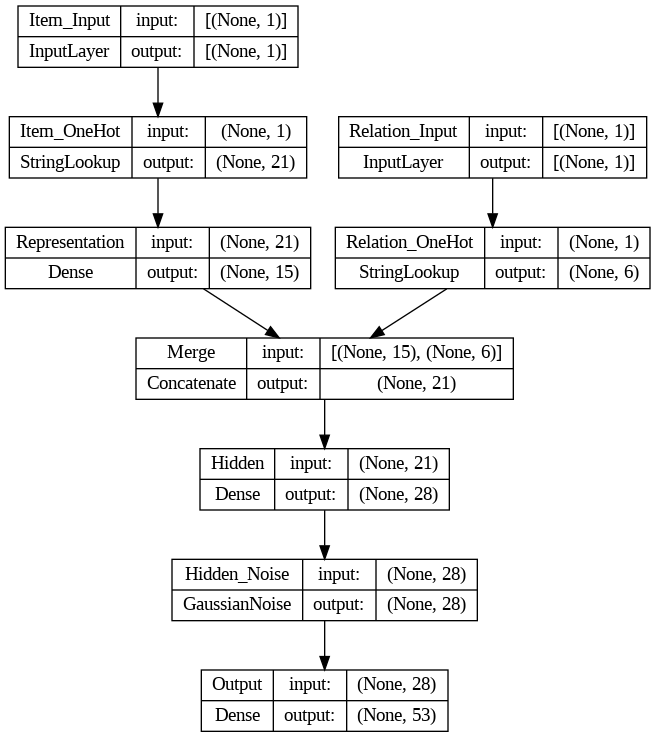

In [57]:
# Plot
tf.keras.utils.plot_model(
    sim_development_model,
    to_file="semantic_simulation_5.4_development_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

In [58]:
# Alternative Compile..?
sim_development_model.compile(
    optimizer="adam",
    loss="mse"
)

In [59]:
# Sample data function
def get_training_data(num_samples, frequency_table):
    # Sample each pattern randomly 1000 times per epoch
    input_table = frequency_table.iloc[np.random.choice(len(frequency_table), size=num_samples, replace=True, p=frequency_table['Probability'])]
    x_item = input_table['Item'].values
    x_relation = input_table['Relation'].values
    attributes = appendix_attributes

    # 1000 (ITEMS) * 53 (ATTRIBUTES) matrix
    y_attributes = np.zeros((len(input_table), len(attributes)))

    attribute_cache = { }

    for i in np.arange(len(x_item)):
        item = x_item[i]
        relation = x_relation[i]

        cache_hit = False

        if item in attribute_cache:
            if relation in attribute_cache[item]:
                y_attributes[i] = attribute_cache[item][relation]
                cache_hit = True
        else:
            attribute_cache[item] = {}

        if not cache_hit:
            item_attributes = appendix_data[item]
            # Soft targets used for training patterns -> active attributes in y_attributes set to 0.95; inactive set to 0.05
            item_attributes = item_attributes.where(item_attributes == 1, other = 0.05)
            item_attributes = item_attributes.where(item_attributes == 0.05, other = 0.95)
            attributes_in_relation = item_attributes.where(appendix_data['Relation'] == relation, other = 0.05)
            y_attributes[i] = attributes_in_relation
            attribute_cache[item][relation] = attributes_in_relation

    return (x_item, x_relation, y_attributes)

#### Define Query Input Combinations

In [60]:
df_isa_basic_combinations = pd.DataFrame({
    'Item': np.repeat(['Oak', 'Robin', 'Goat'], 9), # 9 ISA-BASIC
    'Relation': np.tile(['ISA-BASIC'], 9*3), # Oak, Robin, Goat
    'variable': np.tile(['Tree', 'Flower', 'Bird', 'Fish', 'Cat', 'Dog', 'Mouse', 'Goat', 'Pig'], 3)
})
df_isa_basic_combinations

,Item,Relation,variable
0,Oak,ISA-BASIC,Tree
1,Oak,ISA-BASIC,Flower
2,Oak,ISA-BASIC,Bird
3,Oak,ISA-BASIC,Fish
4,Oak,ISA-BASIC,Cat
5,Oak,ISA-BASIC,Dog
6,Oak,ISA-BASIC,Mouse
7,Oak,ISA-BASIC,Goat
8,Oak,ISA-BASIC,Pig
9,Robin,ISA-BASIC,Tree


#### Define Fit Function for Development Model

In [61]:
# Fit
def fit_sim_development_model(development_model, x_query_items, x_query_relations, input_table):
    predictions = []

    for epoch in np.arange(0, 5200, 200): # just need one loop; 200, 200, 200...
        (x_item, x_relation, y_attributes) = get_training_data(1000 * 200, input_table) #how many input-output pairs randomly grab

        development_model.fit(
            x=[x_item, x_relation],
            y=y_attributes,
            batch_size=100, # how many training pairs before update weights
            epochs=1 # how many times it runs thru the whole training data set
        )
        query_epochs = development_model.predict([x_query_items, x_query_relations])

        query_df = pd.DataFrame(query_epochs, columns=appendix_attributes)
        query_df['Item'] = x_query_items
        query_df['Relation'] = x_query_relations
        query_data_long = pd.melt(query_df, id_vars=['Item', 'Relation'])
        query_data_long['Epoch'] = epoch

        predictions.append(query_data_long)

    return predictions

#### Training the Model

##### Dogs Equally Frequent

In [62]:
query_items_1x = np.array(['Oak', 'Robin', 'Goat'], dtype="str")
query_relations_1x = np.array(['ISA-BASIC'], dtype="str")

x_query_items_1x = np.repeat(query_items_1x, len(query_relations_1x))
x_query_relations_1x = np.repeat(query_relations_1x, len(query_items_1x))

In [63]:
query_data_1x = pd.concat(fit_sim_development_model(sim_development_model, x_query_items_1x, x_query_relations_1x, appendix_full_table_1x))

1/1 [==============================] - 0s 72ms/step


In [64]:
df_isa_basic_combinations_filtered_1x = query_data_1x.merge(df_isa_basic_combinations, on=['Item', 'Relation', 'variable'], how='inner')
df_isa_basic_combinations_filtered_1x

,Item,Relation,variable,value,Epoch
0,Oak,ISA-BASIC,Tree,0.524522,0
1,Oak,ISA-BASIC,Tree,0.773202,200
2,Oak,ISA-BASIC,Tree,0.871904,400
3,Oak,ISA-BASIC,Tree,0.912053,600
4,Oak,ISA-BASIC,Tree,0.912136,800
...,...,...,...,...,...
697,Goat,ISA-BASIC,Pig,0.052512,4200
698,Goat,ISA-BASIC,Pig,0.055549,4400
699,Goat,ISA-BASIC,Pig,0.055090,4600
700,Goat,ISA-BASIC,Pig,0.054893,4800


In [65]:
appendix_dogs_1x_diagram = (ggplot(df_isa_basic_combinations_filtered_1x, mapping=aes(x="Epoch", y="value", color="variable"))+
                             geom_line(data=df_isa_basic_combinations_filtered_1x[df_isa_basic_combinations_filtered_1x["variable"] != "Dog"])+
                             geom_point(data=df_isa_basic_combinations_filtered_1x[df_isa_basic_combinations_filtered_1x["variable"] != "Dog"], size=1)+
                             geom_point(data=df_isa_basic_combinations_filtered_1x[df_isa_basic_combinations_filtered_1x["variable"] == "Dog"], color="black", size=1)+
                             geom_line(data=df_isa_basic_combinations_filtered_1x[df_isa_basic_combinations_filtered_1x["variable"] == "Dog"], color="black")+
                             geom_text(data=df_isa_basic_combinations_filtered_1x[df_isa_basic_combinations_filtered_1x["variable"] == "Dog"], mapping=aes(label="'D'"), color="black", nudge_y=0.015)+
                             facet_wrap("Item", ncol=3)+
                             labs(caption = "Activations for ”Goat\", \"Oak\" and \"Robin\" when dog patterns are 1x as frequent as other mammal patterns in the environment.\nLine in black represents activations for \"dog\".")+
                             theme(figure_size=(16,8), plot_caption=element_text(hjust=0, size="16", lineheight=1.5)))

##### Dogs 8x More Frequent

In [66]:
# Layers
sim_development_item_input_layer_8x = tf.keras.layers.Input(1, name="Item_Input", dtype="string")
sim_development_relation_input_layer_8x = tf.keras.layers.Input(1, name="Relation_Input", dtype="string")

sim_development_item_onehot_layer_8x = tf.keras.layers.StringLookup(name="Item_OneHot", vocabulary=appendix_item_names, num_oov_indices=0, output_mode="one_hot")(sim_development_item_input_layer_8x)
sim_development_relation_onehot_layer_8x = tf.keras.layers.StringLookup(name="Relation_OneHot", vocabulary=appendix_relation_names, num_oov_indices=0, output_mode="one_hot")(sim_development_relation_input_layer_8x)

# representation layer: 15 units
# weights initialized to values from uniform distribution centered at 0, range of -0.9 to 0.9
sim_development_representation_layer_8x = tf.keras.layers.Dense(15, activation="sigmoid", name="Representation", kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9))(sim_development_item_onehot_layer_8x)

sim_development_merge_input_layer_8x = tf.keras.layers.Concatenate(name="Merge")([sim_development_representation_layer_8x, sim_development_relation_onehot_layer_8x])

# hidden layer: 28 units
# same -0.9 to 0.9 weight distribution
sim_development_hidden_layer_8x = tf.keras.layers.Dense(28, activation="sigmoid",  kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9), name="Hidden")(sim_development_merge_input_layer_8x)

# 0.05 variance Gaussian noise
sim_development_noise_layer_8x = tf.keras.layers.GaussianNoise(0.05, name="Hidden_Noise")(sim_development_hidden_layer_8x)

# -2 bias
sim_development_output_layer_8x = tf.keras.layers.Dense(len(appendix_attributes),  kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9), activation="sigmoid", name="Output", bias_initializer=tf.keras.initializers.constant(-2))(sim_development_noise_layer_8x)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [67]:
# Build
sim_development_model_8x = tf.keras.Model(inputs=[sim_development_item_input_layer_8x, sim_development_relation_input_layer_8x], outputs=sim_development_output_layer_8x, name="Semantic_Cognition_Simulation_5.4_Model")

In [68]:
# Compile
sim_development_model_8x.compile(
    optimizer="adam",
    loss="mse"
)

In [69]:
query_items_8x = np.array(['Oak', 'Robin', 'Goat'], dtype="str")
query_relations_8x = np.array(['ISA-BASIC'], dtype="str")

x_query_items_8x = np.repeat(query_items_8x, len(query_relations_8x))
x_query_relations_8x = np.repeat(query_relations_8x, len(query_items_8x))

query_data_8x = pd.concat(fit_sim_development_model(sim_development_model_8x, x_query_items_8x, x_query_relations_8x, appendix_full_table_8x))

1/1 [==============================] - 0s 20ms/step


In [70]:
df_isa_basic_combinations_filtered_8x = query_data_8x.merge(df_isa_basic_combinations, on=['Item', 'Relation', 'variable'], how='inner')
df_isa_basic_combinations_filtered_8x

,Item,Relation,variable,value,Epoch
0,Oak,ISA-BASIC,Tree,0.159902,0
1,Oak,ISA-BASIC,Tree,0.570354,200
2,Oak,ISA-BASIC,Tree,0.766532,400
3,Oak,ISA-BASIC,Tree,0.799403,600
4,Oak,ISA-BASIC,Tree,0.814081,800
...,...,...,...,...,...
697,Goat,ISA-BASIC,Pig,0.057268,4200
698,Goat,ISA-BASIC,Pig,0.057647,4400
699,Goat,ISA-BASIC,Pig,0.056553,4600
700,Goat,ISA-BASIC,Pig,0.055392,4800


In [71]:
appendix_dogs_8x_diagram = (ggplot(df_isa_basic_combinations_filtered_8x, mapping=aes(x="Epoch", y="value", color="variable"))+
                             geom_line(data=df_isa_basic_combinations_filtered_8x[df_isa_basic_combinations_filtered_8x["variable"] != "Dog"])+
                             geom_point(data=df_isa_basic_combinations_filtered_8x[df_isa_basic_combinations_filtered_8x["variable"] != "Dog"], size=1)+
                             geom_point(data=df_isa_basic_combinations_filtered_8x[df_isa_basic_combinations_filtered_8x["variable"] == "Dog"], color="black", size=1)+
                             geom_line(data=df_isa_basic_combinations_filtered_8x[df_isa_basic_combinations_filtered_8x["variable"] == "Dog"], color="black")+
                             geom_text(data=df_isa_basic_combinations_filtered_8x[df_isa_basic_combinations_filtered_8x["variable"] == "Dog"], mapping=aes(label="'D'"), color="black", nudge_y=0.015)+
                             facet_wrap("Item", ncol=3)+
                             labs(caption = "Activations for ”Goat\", \"Oak\" and \"Robin\" when dog patterns are 8x as frequent as other mammal patterns in the environment.\nLine in black represents activations for \"dog\".")+
                             theme(figure_size=(16,8), plot_caption=element_text(hjust=0, size="16", lineheight=1.5)))

##### Dogs 16x More Frequent

In [72]:
# Layers
sim_development_item_input_layer_16x = tf.keras.layers.Input(1, name="Item_Input", dtype="string")
sim_development_relation_input_layer_16x = tf.keras.layers.Input(1, name="Relation_Input", dtype="string")

sim_development_item_onehot_layer_16x = tf.keras.layers.StringLookup(name="Item_OneHot", vocabulary=appendix_item_names, num_oov_indices=0, output_mode="one_hot")(sim_development_item_input_layer_16x)
sim_development_relation_onehot_layer_16x = tf.keras.layers.StringLookup(name="Relation_OneHot", vocabulary=appendix_relation_names, num_oov_indices=0, output_mode="one_hot")(sim_development_relation_input_layer_16x)

# representation layer: 15 units
# weights initialized to values from uniform distribution centered at 0, range of -0.9 to 0.9
sim_development_representation_layer_16x = tf.keras.layers.Dense(15, activation="sigmoid", name="Representation", kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9))(sim_development_item_onehot_layer_16x)

sim_development_merge_input_layer_16x = tf.keras.layers.Concatenate(name="Merge")([sim_development_representation_layer_16x, sim_development_relation_onehot_layer_16x])

# hidden layer: 28 units
# same -0.9 to 0.9 weight distribution
sim_development_hidden_layer_16x = tf.keras.layers.Dense(28, activation="sigmoid",  kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9), name="Hidden")(sim_development_merge_input_layer_16x)

# 0.05 variance Gaussian noise
sim_development_noise_layer_16x = tf.keras.layers.GaussianNoise(0.05, name="Hidden_Noise")(sim_development_hidden_layer_16x)

# -2 bias
sim_development_output_layer_16x = tf.keras.layers.Dense(len(appendix_attributes),  kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9), activation="sigmoid", name="Output", bias_initializer=tf.keras.initializers.constant(-2))(sim_development_noise_layer_16x)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [73]:
# Build
sim_development_model_16x = tf.keras.Model(inputs=[sim_development_item_input_layer_16x, sim_development_relation_input_layer_16x], outputs=sim_development_output_layer_16x, name="Semantic_Cognition_Simulation_5.4_Model")

In [74]:
# Alternative Compile..?
sim_development_model_16x.compile(
    optimizer="adam",
    loss="mse"
)

In [75]:
query_items_16x = np.array(['Oak', 'Robin', 'Goat'], dtype="str")
query_relations_16x = np.array(['ISA-BASIC'], dtype="str")

x_query_items_16x = np.repeat(query_items_16x, len(query_relations_16x))
x_query_relations_16x = np.repeat(query_relations_16x, len(query_items_16x))

query_data_16x = pd.concat(fit_sim_development_model(sim_development_model_16x, x_query_items_16x, x_query_relations_16x, appendix_full_table_16x))

1/1 [==============================] - 0s 21ms/step


In [76]:
df_isa_basic_combinations_filtered_16x = query_data_16x.merge(df_isa_basic_combinations, on=['Item', 'Relation', 'variable'], how='inner')
df_isa_basic_combinations_filtered_16x

,Item,Relation,variable,value,Epoch
0,Oak,ISA-BASIC,Tree,0.209039,0
1,Oak,ISA-BASIC,Tree,0.570524,200
2,Oak,ISA-BASIC,Tree,0.700209,400
3,Oak,ISA-BASIC,Tree,0.758377,600
4,Oak,ISA-BASIC,Tree,0.797870,800
...,...,...,...,...,...
697,Goat,ISA-BASIC,Pig,0.050858,4200
698,Goat,ISA-BASIC,Pig,0.053674,4400
699,Goat,ISA-BASIC,Pig,0.054349,4600
700,Goat,ISA-BASIC,Pig,0.052227,4800


In [77]:
appendix_dogs_16x_diagram = (ggplot(df_isa_basic_combinations_filtered_16x, mapping=aes(x="Epoch", y="value", color="variable"))+
                             geom_line(data=df_isa_basic_combinations_filtered_16x[df_isa_basic_combinations_filtered_16x["variable"] != "Dog"])+
                             geom_point(data=df_isa_basic_combinations_filtered_16x[df_isa_basic_combinations_filtered_16x["variable"] != "Dog"], size=1)+
                             geom_point(data=df_isa_basic_combinations_filtered_16x[df_isa_basic_combinations_filtered_16x["variable"] == "Dog"], color="black", size=1)+
                             geom_line(data=df_isa_basic_combinations_filtered_16x[df_isa_basic_combinations_filtered_16x["variable"] == "Dog"], color="black")+
                             geom_text(data=df_isa_basic_combinations_filtered_16x[df_isa_basic_combinations_filtered_16x["variable"] == "Dog"], mapping=aes(label="'D'"), color="black", nudge_y=0.015)+
                             facet_wrap("Item", ncol=3)+
                             labs(caption = "Activations for ”Goat\", \"Oak\" and \"Robin\" when dog patterns are 16x as frequent as other mammal patterns in the environment.\nLine in black represents activations for \"dog\".")+
                             theme(figure_size=(16,8), plot_caption=element_text(hjust=0, size="16", lineheight=1.5)))

#### Comparison of ISA-BASIC Activations when 'Dog' Stimuli Appear Equally Frequent, 8x More Frequent and 16x More Frequent

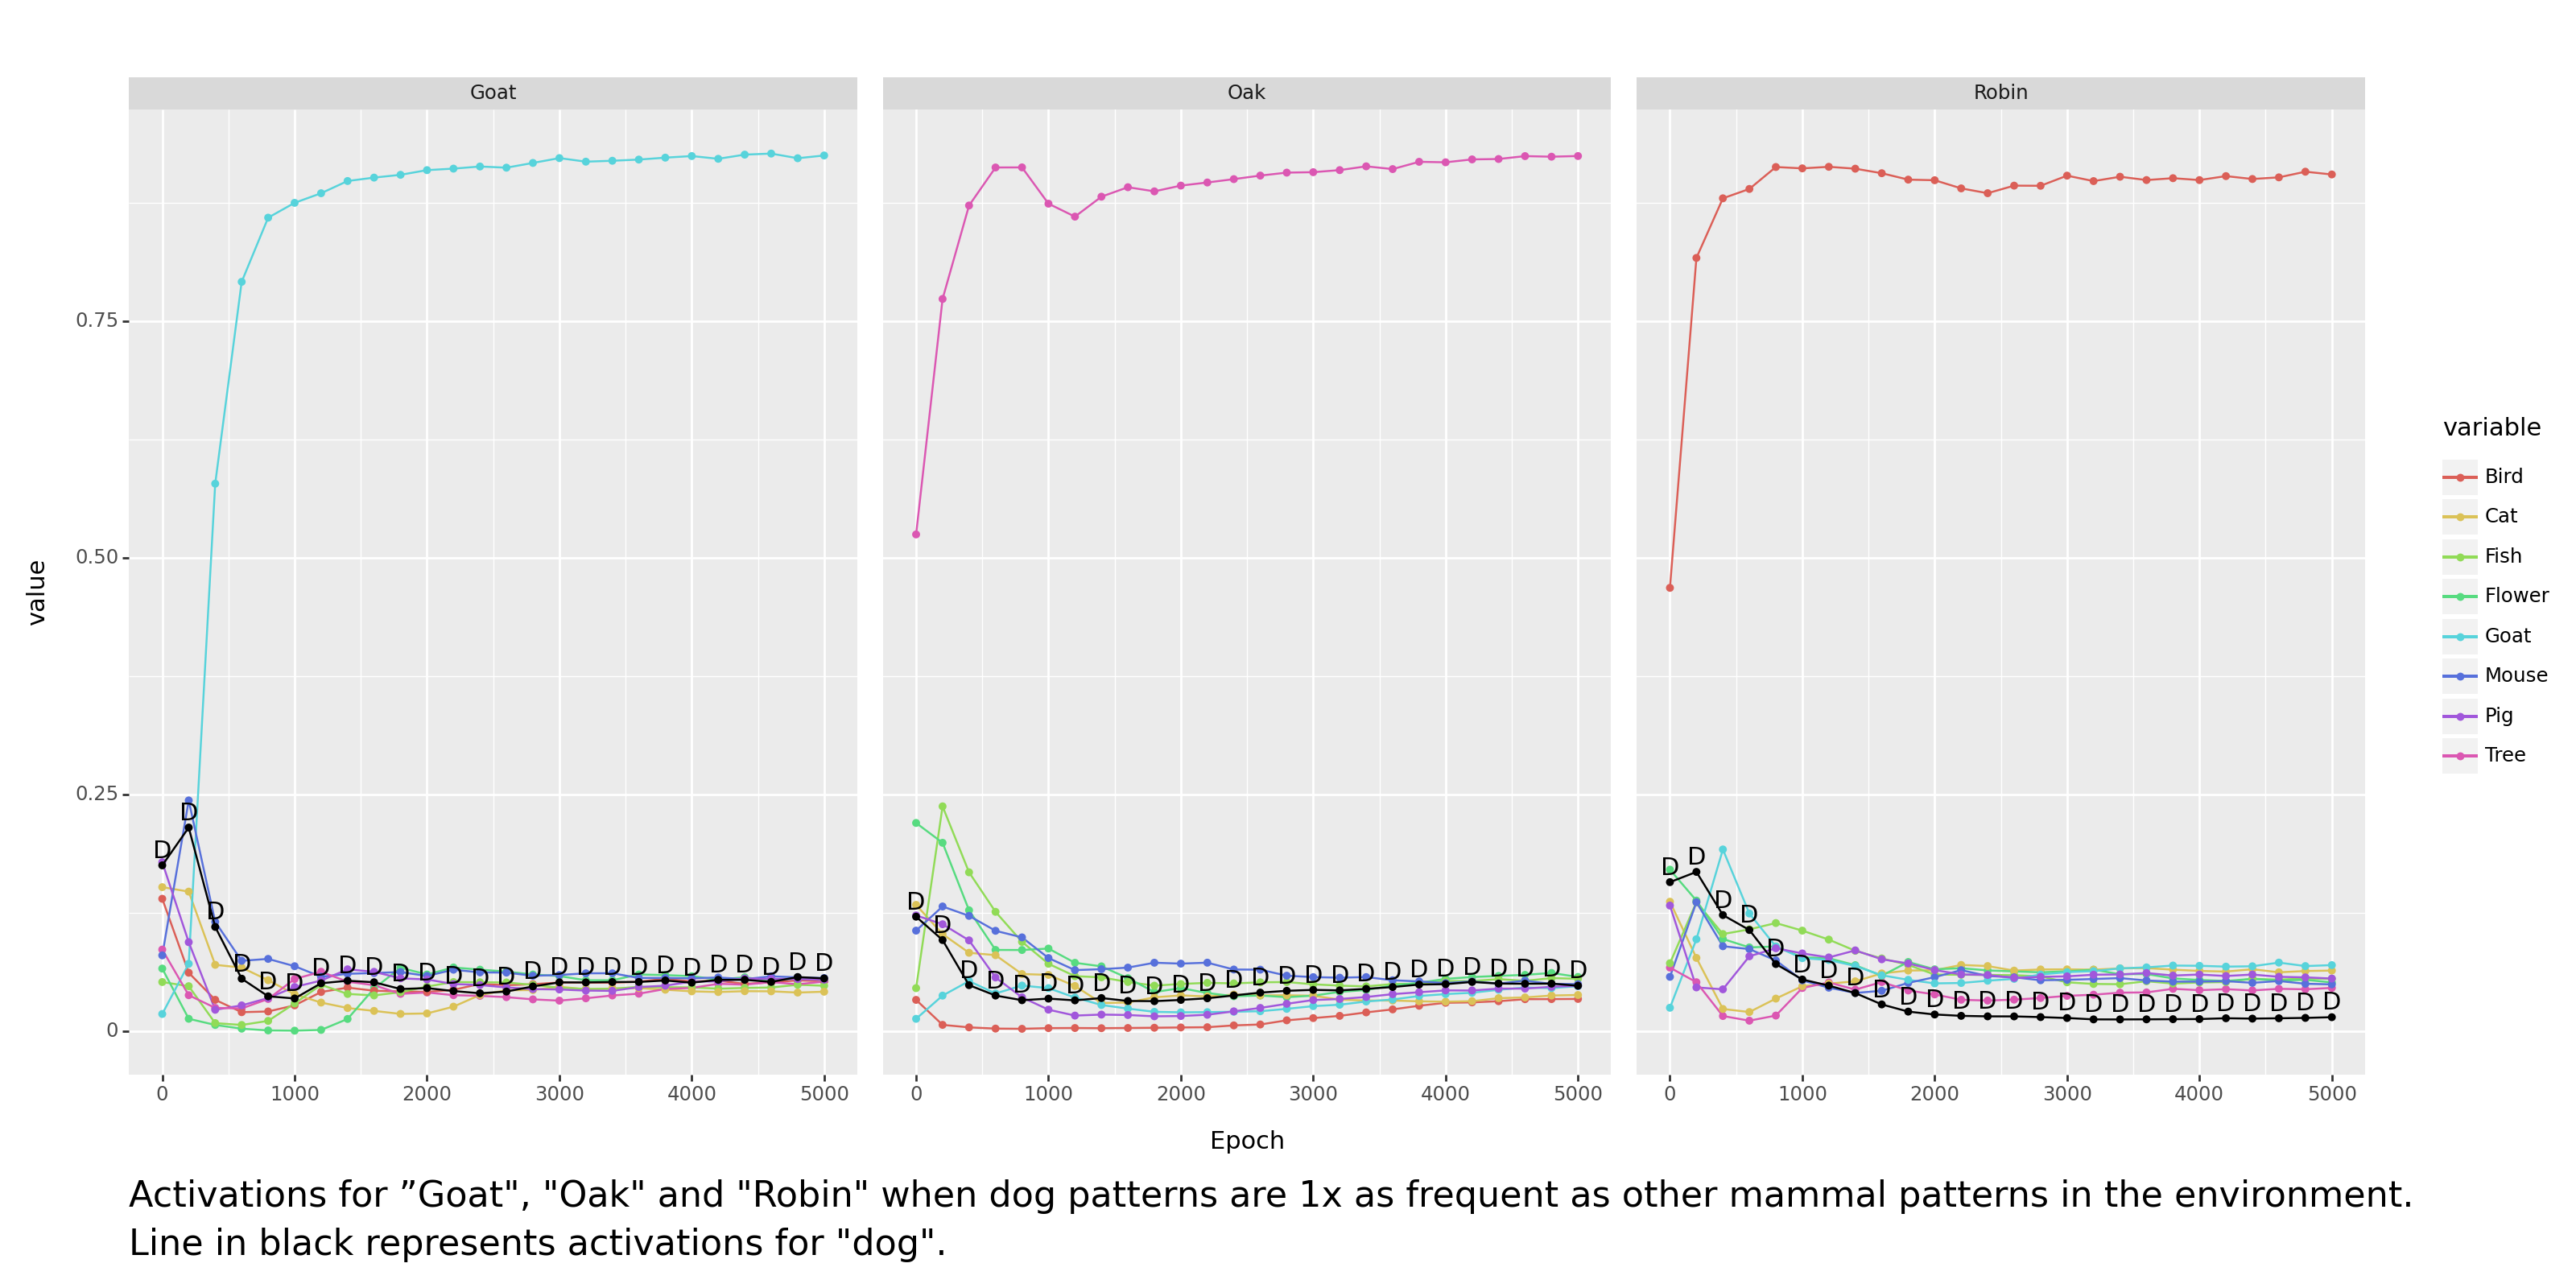

<Figure Size: (1600 x 800)>

In [78]:
appendix_dogs_1x_diagram

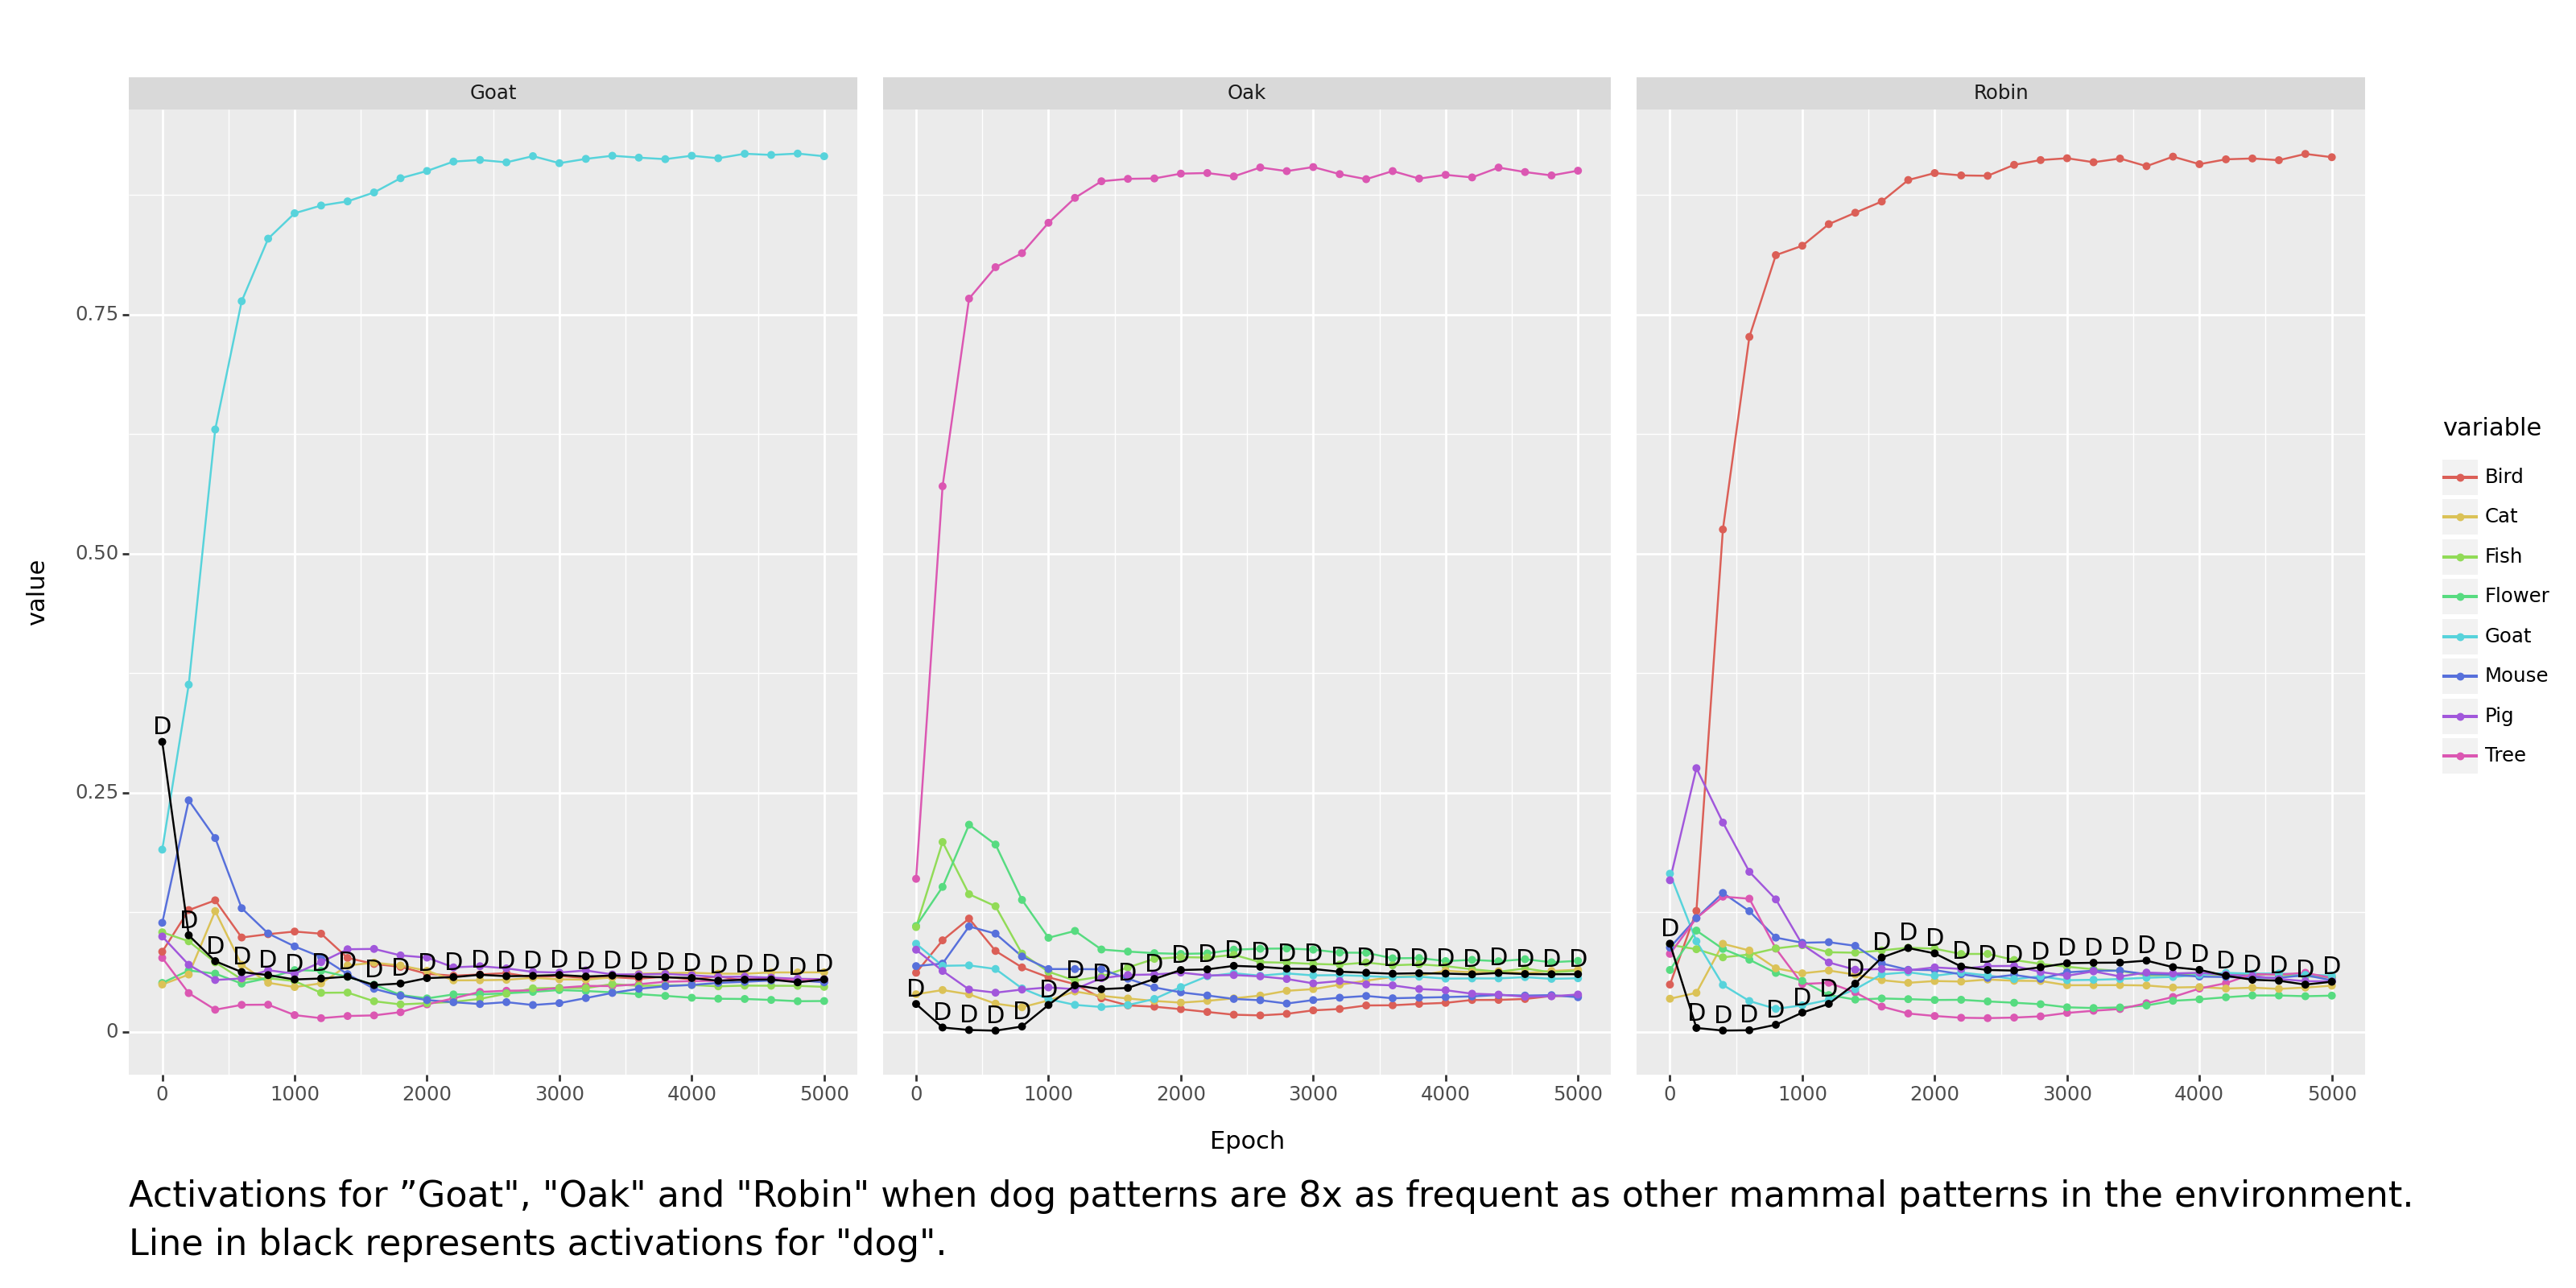

<Figure Size: (1600 x 800)>

In [79]:
appendix_dogs_8x_diagram

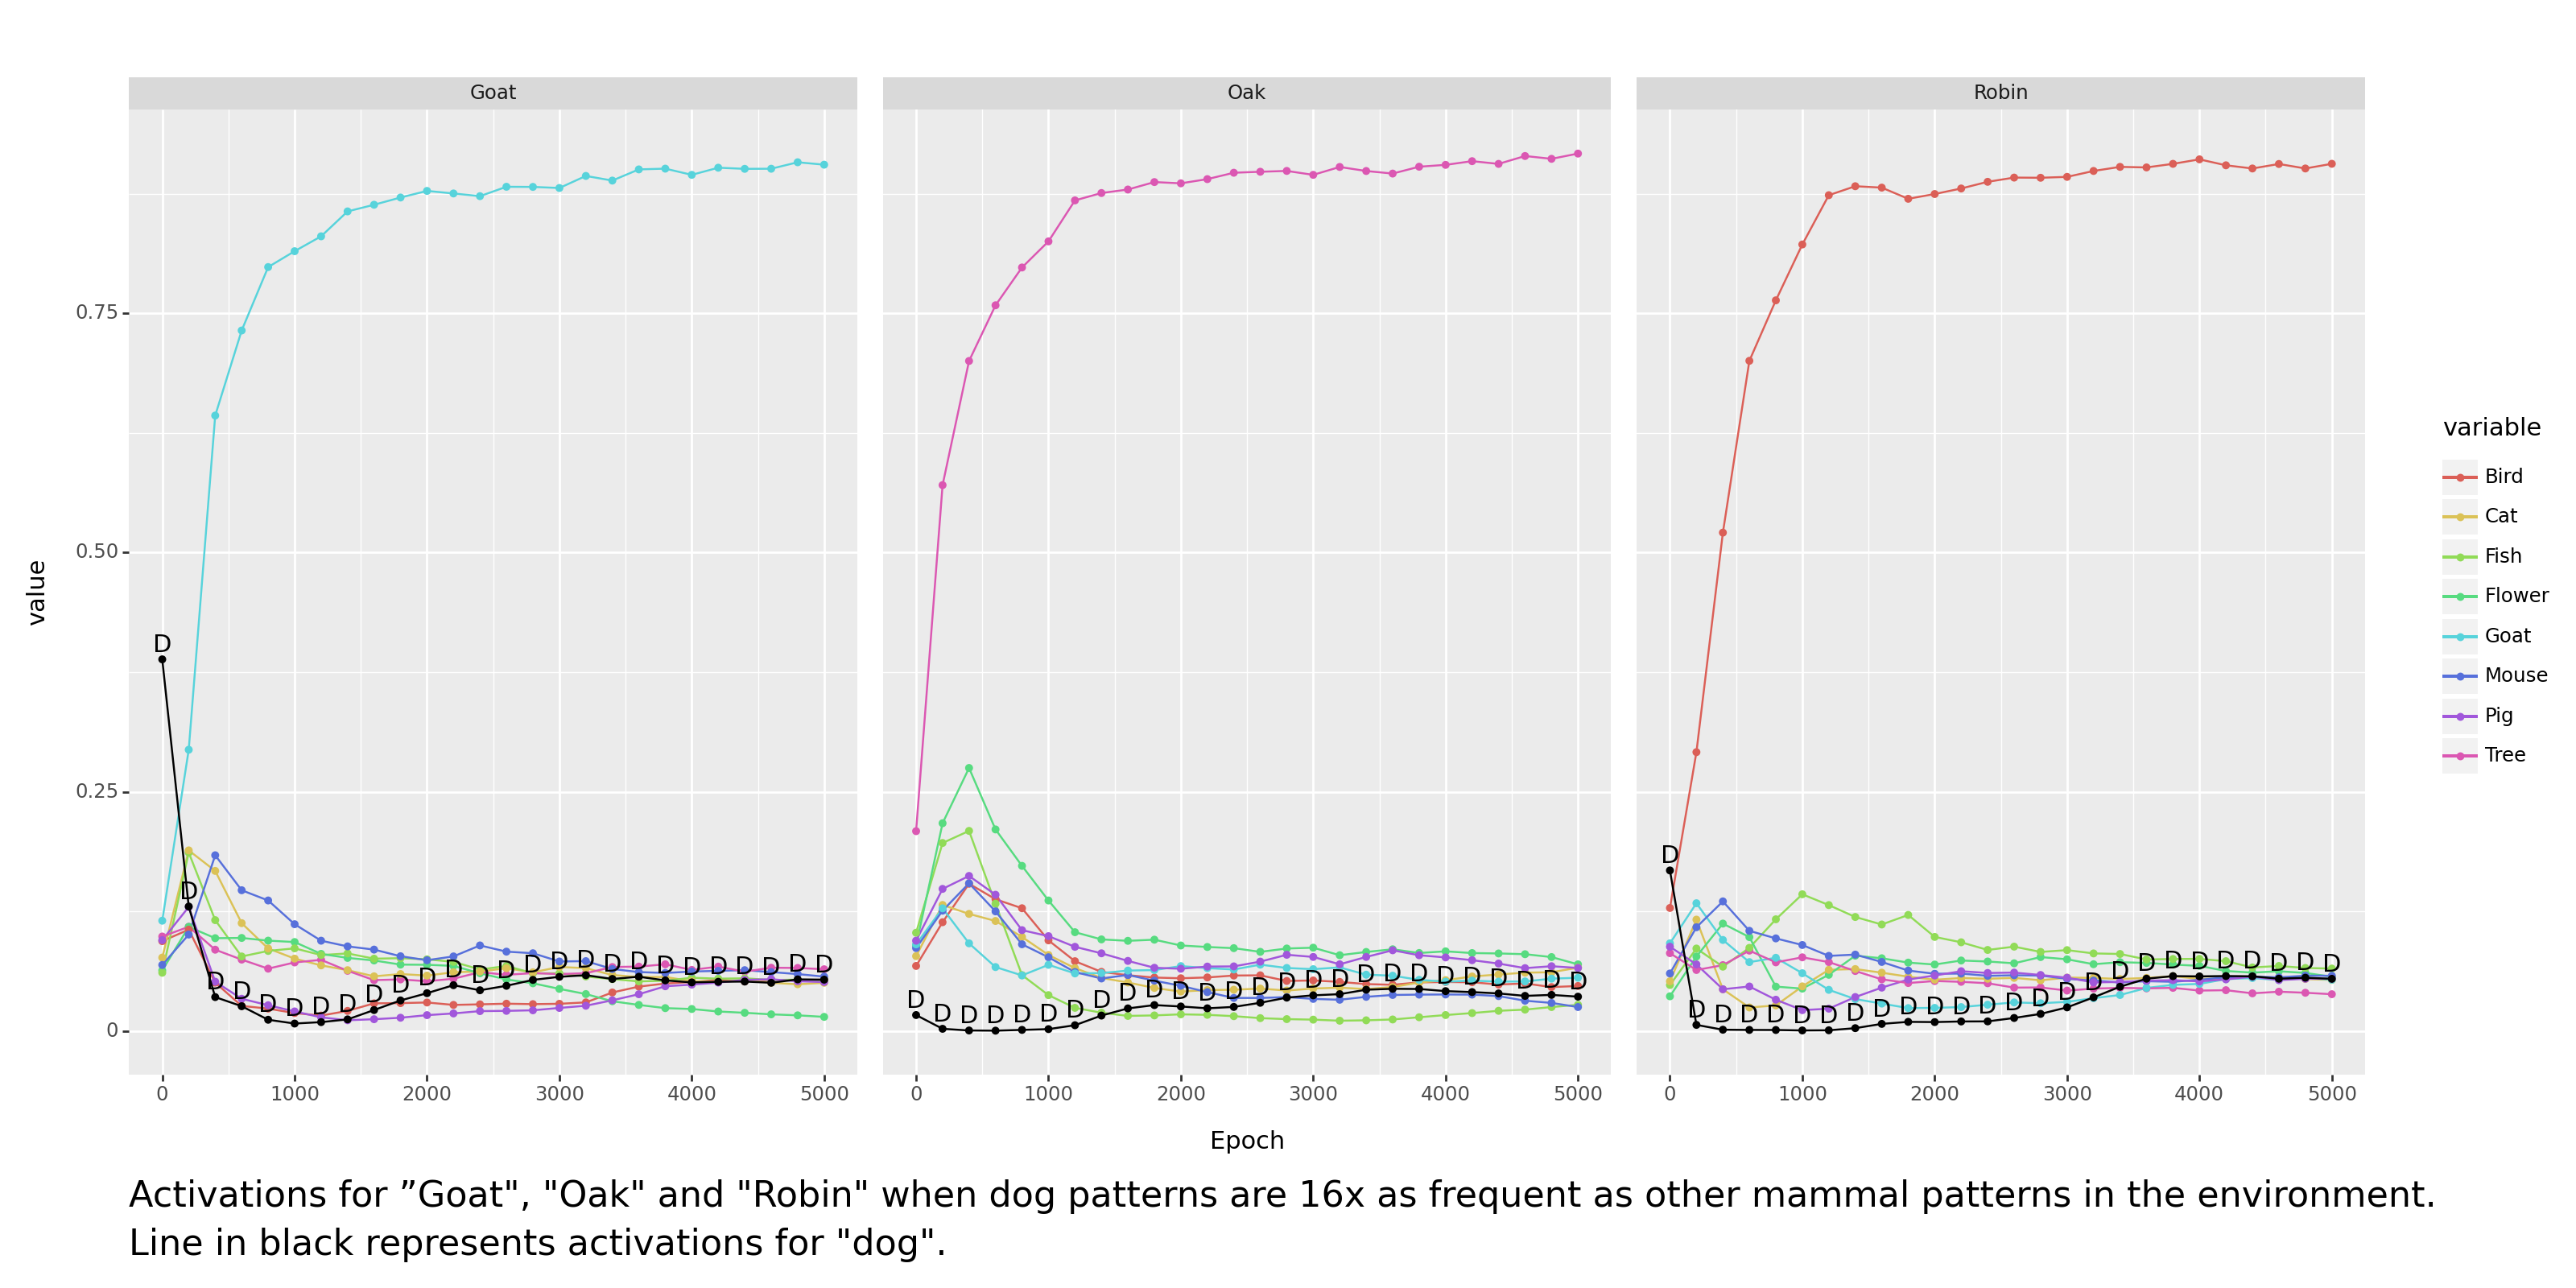

<Figure Size: (1600 x 800)>

In [80]:
appendix_dogs_16x_diagram

As the above figures show, the network tends to inappropriately activate the basic name 'dog' when dog patterns appear more frequently in the training set (8x, 16x) than when they appear equally frequently as other mammals (1x). In all three cases (1x, 8x, 16x) and across all three sampled items, "Goat", "Oak", and "Robin", there is first a relatively high activation for "dog" before a sharp decline during the first 500-1000 epochs. The activation for "dog" then tends to stabilize at a level around 0.04-0.07.

Similar to Rogers and McClelland's results in the book, the initial activations for "dog" are highest when dog patterns appear 16x more frequent, followed by when they appear 8x more frequent; and when dog patterns appear as frequently as other mammals, the intiial activations for "dog" do not seem particularly higher than other incorrect basic names. For instance, for "Goat", initial activations for "mouse", "pig" and "cat" were higher than for "dog", and for "Oak" "flower" was higher than "dog". This agrees with the idea that the more frequent a particular set of patterns appear in a model's training data set, the more its weights are fitted to it, such that it mistakenly activates the pattern more strongly even when the prediction input does not match the pattern. This simulates the observation in human categorization where the more familiar a basic name or concept is, the more humans may over-extend the name to label objects that do not belong in its category.

Moreover, this overgeneralization of familiar names is modulated by the similarity between the name and the object being incorrectly labelled. For both the 8x and 16x case, the initial "dog" activations for "Goat" were highest, because goats share more attributes with dogs than the other two (this is followed by "Robin", which is more similar to "Dog" than "Oak". While the 8x diagram results mirror those of Rogers and McClelland, showing the initial dog activations of "Robin" to be higher than "Oak", it is unclear why this pattern is not observed in the 16x case). Overextension of familiar labels is therefore dependent on both frequency of exposure to the label (a particular basic name in this case), as well as the degree of differentiation between objects under the label and the mistakenly labelled object, which should mirror the natural similarity patterns between these two objects and be reflected in the training corpus of a model.

_Sidenote:_
Is there some predictable way these activations scale? Like could `dog_activation(16x)` be described as a function of `dog_activation(8x)` and `dog_activation(1x)` where `dog_activation(1x)` acts as a basis.

### Effects of Damage: Simulating Over-extension of Familiar Basic Names in Dementia

**Simulation Strategy (from ch.3):**
1. On each damage trial add a random value (selected from a Gaussian distribution with a mean of zero and a fixed variance) to each weight projecting from the Item to the Representation layer
    - **If implement as a layer in the architecture, will have to build, compile and fit separately for each damage trial. Instead, can "inject" the noise into the weights coming out from item layer.**
    - **Josh: It's a range cuz...maybe 0-1, 1-2, 2-3, 3-4? Maybe this explains why there is 50 trials for each level.**
2. Step through all the patterns in the network’s environment and record the states of its Representation and Attribute units in response to each input
   - **aka record for each ITEM-ISA-BASIC pair the output attribute and whether it's right**
   - **I don't think we actually need the states of its Representation units**
4. Reload the correct, learned set of weights, and started a new damage trial
   - **The initial weights, without noise injection.**
5. 5 damage levels: 0, 1, 2, 3, 4
6. For each level of damage, conduct 50 damage trials
   - **Sum number of errorenous use of each basic name**

##### Define Dataframes for all ITEM-ISA-BASIC Pairs

In [81]:
mammal_item_names = np.array(["Cat", "Dog", "Mouse", "Goat", "Pig"], dtype="str")
x_dementia_query_items = mammal_item_names
x_dementia_query_relations = np.repeat("ISA-BASIC", len(x_dementia_query_items))

In [82]:
def dementia_query(dementia_model, x_query_items, x_query_relations):
    query_data = dementia_model([x_query_items, x_query_relations])

    query_df = pd.DataFrame(query_data, columns=appendix_attributes)
    query_df['Item'] = x_query_items
    query_df['Relation'] = x_query_relations
    query_df_long = pd.melt(query_df, id_vars=['Item', 'Relation'])

    return query_df_long

##### Define Model

In [83]:
def build_dementia_model():
    # Layers
    sim_dementia_item_input_layer = tf.keras.layers.Input(1, name="Item_Input", dtype="string")
    sim_dementia_relation_input_layer = tf.keras.layers.Input(1, name="Relation_Input", dtype="string")

    sim_dementia_items_onehot_layer = tf.keras.layers.StringLookup(name="Item_OneHot", vocabulary=appendix_item_names, num_oov_indices=0, output_mode="one_hot")(sim_dementia_item_input_layer)
    sim_dementia_relations_onehot_layer = tf.keras.layers.StringLookup(name="Relation_OneHot", vocabulary=appendix_relation_names, num_oov_indices=0, output_mode="one_hot")(sim_dementia_relation_input_layer)

    # representation layer: 15 units
    # weights initialized to values from uniform distribution centered at 0, range of -0.9 to 0.9
    sim_dementia_representation_layer = tf.keras.layers.Dense(15, activation="sigmoid", name="Representation", kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9))(sim_dementia_items_onehot_layer)

    sim_dementia_merge_input_layer = tf.keras.layers.Concatenate(name="Merge")([sim_dementia_representation_layer, sim_dementia_relations_onehot_layer])

    # hidden layer: 28 units
    # same -0.9 to 0.9 weight distribution
    sim_dementia_hidden_layer = tf.keras.layers.Dense(28, activation="sigmoid",  kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9), name="Hidden")(sim_dementia_merge_input_layer)

    # 0.05 variance Gaussian noise
    sim_dementia_noise_layer = tf.keras.layers.GaussianNoise(0.05, name="Hidden_Noise")(sim_dementia_hidden_layer)

    # -2 bias
    sim_dementia_output_layer = tf.keras.layers.Dense(len(appendix_attributes),  kernel_initializer=tf.keras.initializers.random_uniform(minval=-.9, maxval=.9), activation="sigmoid", name="Output", bias_initializer=tf.keras.initializers.constant(-2))(sim_dementia_noise_layer)

    # Build
    sim_dementia_model = tf.keras.Model(inputs=[sim_dementia_item_input_layer, sim_dementia_relation_input_layer], outputs=sim_dementia_output_layer, name="Semantic_Cognition_Simulation_5.4_Dementia_Model")

    # Compile
    sim_dementia_model.compile(
        optimizer="adam",
        loss="mse"
    )

    return sim_dementia_model

In [84]:
# Fit Dementia Model Function (Without Prediction)
def fit_sim_dementia_model(dementia_model, input_table):
    for i in np.arange(0, 5500, 500):
        (x_item, x_relation, y_attributes) = get_training_data(1000 * 500, input_table) #how many input-output pairs randomly grab

        dementia_model.fit(
            x=[x_item, x_relation],
            y=y_attributes,
            batch_size=100, # how many training pairs before update weights
            epochs=1 # how many times it runs thru the whole training data set
        )

##### Define Function for Injecting Noise into Representation Layer

In [85]:
import keras.backend as K

def set_representation_weights_noise(dementia_model, noise_level):
    layer_weights = dementia_model.get_layer('Representation').get_weights()

    # Generate random noise with the same shape as layer_weights
    noise_shape = K.shape(layer_weights[0])  # Get the shape of the first array (assuming weights[0] is the kernel matrix (two-dimensional array)
    noise = K.random_normal(shape=noise_shape, mean=0.0, stddev=noise_level)

    # Add the noise to the weights
    noisy_weights = [layer_weights[0] + noise, layer_weights[1]]  # Assuming weights[1] is the bias (one-dimensional array)

    # Set the noisy weights back to the model
    dementia_model.get_layer('Representation').set_weights(noisy_weights)

##### Define Function for Prediction

In [86]:
def simulate_damage_query(noise, dementia_model, correct_weights, x_query_items, x_query_relations, repeats):
    predictions = pd.DataFrame()

    for i in np.arange(repeats):
        set_representation_weights_noise(dementia_model, noise)
        query_results = dementia_query(dementia_model, x_query_items, x_query_relations)
        query_results = query_results[query_results['variable'].isin(mammal_item_names)]
        query_results = query_results[query_results['value'] > 0.7]
        predictions = pd.concat([predictions, query_results])

        dementia_model.load_weights(correct_weights)

    return predictions

#### Simulating Dementia in Model Trained on 1x Dog Pattern Frequency

In [87]:
sim_dementia_model_1x = build_dementia_model()

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


##### Training the Model

In [88]:
# Fit
fit_sim_dementia_model(sim_dementia_model_1x, appendix_full_table_1x)

5000/5000 [==============================] - 55s 11ms/step - loss: 2.2982e-04


In [89]:
# Save correct weights
sim_dementia_model_1x.save_weights('dementia_correct_weights_1x.h5')

##### Clone "Healthy" Trained Model

In [90]:
from keras.models import clone_model

# Clone the model
sim_dementia_model_1x_0 = clone_model(sim_dementia_model_1x)
sim_dementia_model_1x_0.set_weights(sim_dementia_model_1x.get_weights())

sim_dementia_model_1x_1 = clone_model(sim_dementia_model_1x)
sim_dementia_model_1x_1.set_weights(sim_dementia_model_1x.get_weights())

sim_dementia_model_1x_2 = clone_model(sim_dementia_model_1x)
sim_dementia_model_1x_2.set_weights(sim_dementia_model_1x.get_weights())

sim_dementia_model_1x_3 = clone_model(sim_dementia_model_1x)
sim_dementia_model_1x_3.set_weights(sim_dementia_model_1x.get_weights())

sim_dementia_model_1x_4 = clone_model(sim_dementia_model_1x)
sim_dementia_model_1x_4.set_weights(sim_dementia_model_1x.get_weights())

##### Simulate 0 damage

In [91]:
sim_dementia_results_1x_0 = simulate_damage_query(0.0, sim_dementia_model_1x_0, 'dementia_correct_weights_1x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_1x_0 = sim_dementia_results_1x_0.sort_values(by='Item')
sim_dementia_results_1x_0

,Item,Relation,variable,value
30,Cat,ISA-BASIC,Cat,0.923280
30,Cat,ISA-BASIC,Cat,0.923280
30,Cat,ISA-BASIC,Cat,0.923280
30,Cat,ISA-BASIC,Cat,0.923280
30,Cat,ISA-BASIC,Cat,0.923280
...,...,...,...,...
54,Pig,ISA-BASIC,Pig,0.921878
54,Pig,ISA-BASIC,Pig,0.921878
54,Pig,ISA-BASIC,Pig,0.921878
54,Pig,ISA-BASIC,Pig,0.921878


In [92]:
sim_dementia_wrong_results_1x_0 = sim_dementia_results_1x_0[sim_dementia_results_1x_0["Item"] != sim_dementia_results_1x_0["variable"]]
sim_dementia_wrong_results_1x_0['Damage'] = 0
sim_dementia_wrong_results_1x_0

,Item,Relation,variable,value,Damage


##### Simulate 1 damage

In [93]:
sim_dementia_results_1x_1 = simulate_damage_query(1.0, sim_dementia_model_1x_1, 'dementia_correct_weights_1x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_1x_1 = sim_dementia_results_1x_1.sort_values(by='Item')
sim_dementia_results_1x_1

,Item,Relation,variable,value
30,Cat,ISA-BASIC,Cat,0.926914
30,Cat,ISA-BASIC,Cat,0.902517
30,Cat,ISA-BASIC,Cat,0.904907
30,Cat,ISA-BASIC,Cat,0.900455
30,Cat,ISA-BASIC,Cat,0.920902
...,...,...,...,...
54,Pig,ISA-BASIC,Pig,0.897462
54,Pig,ISA-BASIC,Pig,0.908222
54,Pig,ISA-BASIC,Pig,0.879941
54,Pig,ISA-BASIC,Pig,0.923506


In [94]:
sim_dementia_wrong_results_1x_1 = sim_dementia_results_1x_1[sim_dementia_results_1x_1["Item"] != sim_dementia_results_1x_1["variable"]]
sim_dementia_wrong_results_1x_1['Damage'] = 1
sim_dementia_wrong_results_1x_1

,Item,Relation,variable,value,Damage


##### Simulate 2 damage

In [95]:
sim_dementia_results_1x_2 = simulate_damage_query(2.0, sim_dementia_model_1x_2, 'dementia_correct_weights_1x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_1x_2 = sim_dementia_results_1x_2.sort_values(by='Item')
sim_dementia_results_1x_2

,Item,Relation,variable,value
30,Cat,ISA-BASIC,Cat,0.936170
30,Cat,ISA-BASIC,Cat,0.778254
30,Cat,ISA-BASIC,Cat,0.870860
30,Cat,ISA-BASIC,Cat,0.916393
30,Cat,ISA-BASIC,Cat,0.911883
...,...,...,...,...
54,Pig,ISA-BASIC,Pig,0.721070
54,Pig,ISA-BASIC,Pig,0.840058
54,Pig,ISA-BASIC,Pig,0.747403
54,Pig,ISA-BASIC,Pig,0.853812


In [96]:
sim_dementia_wrong_results_1x_2 = sim_dementia_results_1x_2[sim_dementia_results_1x_2["Item"] != sim_dementia_results_1x_2["variable"]]
sim_dementia_wrong_results_1x_2['Damage'] = 2
sim_dementia_wrong_results_1x_2

<ipython-input-96-d1499bd0b54f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Item,Relation,variable,value,Damage
46,Dog,ISA-BASIC,Goat,0.765881,2


##### Simulate 3 damage

In [97]:
sim_dementia_results_1x_3 = simulate_damage_query(3.0, sim_dementia_model_1x_3, 'dementia_correct_weights_1x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_1x_3 = sim_dementia_results_1x_3.sort_values(by='Item')
sim_dementia_results_1x_3

,Item,Relation,variable,value
30,Cat,ISA-BASIC,Cat,0.878398
30,Cat,ISA-BASIC,Cat,0.779822
40,Cat,ISA-BASIC,Mouse,0.732400
30,Cat,ISA-BASIC,Cat,0.889024
30,Cat,ISA-BASIC,Cat,0.879478
...,...,...,...,...
54,Pig,ISA-BASIC,Pig,0.819524
54,Pig,ISA-BASIC,Pig,0.861796
54,Pig,ISA-BASIC,Pig,0.845933
54,Pig,ISA-BASIC,Pig,0.732655


In [98]:
sim_dementia_wrong_results_1x_3 = sim_dementia_results_1x_3[sim_dementia_results_1x_3["Item"] != sim_dementia_results_1x_3["variable"]]
sim_dementia_wrong_results_1x_3['Damage'] = 3
sim_dementia_wrong_results_1x_3

<ipython-input-98-7ec1cab74f67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Item,Relation,variable,value,Damage
40,Cat,ISA-BASIC,Mouse,0.732400,3
35,Cat,ISA-BASIC,Dog,0.734850,3
41,Dog,ISA-BASIC,Mouse,0.720588,3
46,Dog,ISA-BASIC,Goat,0.710154,3
43,Goat,ISA-BASIC,Mouse,0.878269,3
32,Mouse,ISA-BASIC,Cat,0.759118,3


##### Simulate 4 damage

In [99]:
sim_dementia_results_1x_4 = simulate_damage_query(4.0, sim_dementia_model_1x_4, 'dementia_correct_weights_1x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_1x_4 = sim_dementia_results_1x_4.sort_values(by='Item')
sim_dementia_results_1x_4

,Item,Relation,variable,value
30,Cat,ISA-BASIC,Cat,0.737728
30,Cat,ISA-BASIC,Cat,0.885292
30,Cat,ISA-BASIC,Cat,0.893882
30,Cat,ISA-BASIC,Cat,0.731786
30,Cat,ISA-BASIC,Cat,0.820851
...,...,...,...,...
54,Pig,ISA-BASIC,Pig,0.889371
54,Pig,ISA-BASIC,Pig,0.700026
44,Pig,ISA-BASIC,Mouse,0.731183
54,Pig,ISA-BASIC,Pig,0.806361


In [100]:
sim_dementia_wrong_results_1x_4 = sim_dementia_results_1x_4[sim_dementia_results_1x_4["Item"] != sim_dementia_results_1x_4["variable"]]
sim_dementia_wrong_results_1x_4['Damage'] = 4
sim_dementia_wrong_results_1x_4

<ipython-input-100-6e1ba5f63b4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Item,Relation,variable,value,Damage
45,Cat,ISA-BASIC,Goat,0.837715,4
46,Dog,ISA-BASIC,Goat,0.771664,4
31,Dog,ISA-BASIC,Cat,0.784144,4
46,Dog,ISA-BASIC,Goat,0.732008,4
31,Dog,ISA-BASIC,Cat,0.728959,4
51,Dog,ISA-BASIC,Pig,0.774574,4
43,Goat,ISA-BASIC,Mouse,0.920686,4
33,Goat,ISA-BASIC,Cat,0.813436,4
37,Mouse,ISA-BASIC,Dog,0.711235,4
32,Mouse,ISA-BASIC,Cat,0.713427,4


##### Generate Graph for Naming Mistakes for Model Trained on 1x Dog Frequency

In [101]:
sim_dementia_wrong_results_1x_all = pd.DataFrame()
sim_dementia_wrong_results_1x_all = pd.concat([sim_dementia_wrong_results_1x_all, sim_dementia_wrong_results_1x_0])
sim_dementia_wrong_results_1x_all = pd.concat([sim_dementia_wrong_results_1x_all, sim_dementia_wrong_results_1x_1])
sim_dementia_wrong_results_1x_all = pd.concat([sim_dementia_wrong_results_1x_all, sim_dementia_wrong_results_1x_2])
sim_dementia_wrong_results_1x_all = pd.concat([sim_dementia_wrong_results_1x_all, sim_dementia_wrong_results_1x_3])
sim_dementia_wrong_results_1x_all = pd.concat([sim_dementia_wrong_results_1x_all, sim_dementia_wrong_results_1x_4])

sim_dementia_wrong_results_1x_all = sim_dementia_wrong_results_1x_all.groupby(['variable', 'Damage'], sort=False).size().reset_index(name='Count')
sim_dementia_wrong_results_1x_all

,variable,Damage,Count
0,Goat,2,1
1,Mouse,3,3
2,Dog,3,1
3,Goat,3,1
4,Cat,3,1
5,Goat,4,3
6,Cat,4,5
7,Pig,4,1
8,Mouse,4,2
9,Dog,4,1


In [102]:
sim_dementia_final_results_1x_structure = {'variable': np.tile(mammal_item_names, 5), 'Damage': np.repeat([0, 1, 2, 3, 4], 5)}
sim_dementia_final_results_1x_structure['Count'] = 0
sim_dementia_final_results_1x_all = pd.DataFrame(data=sim_dementia_final_results_1x_structure)
sim_dementia_final_results_1x_all

for row in sim_dementia_wrong_results_1x_all.itertuples(index=False):
    variable = row[0]
    damage = row[1]
    value_to_update = row[2]

    # Find the row in sim_dementia_final_results_1x_all where 'variable' matches and 'Damage' matches
    mask = (sim_dementia_final_results_1x_all['variable'] == variable) & (sim_dementia_final_results_1x_all['Damage'] == damage)

    # Update the 'Count' column with the new value
    sim_dementia_final_results_1x_all.loc[mask, 'Count'] = value_to_update

##### Plot Results

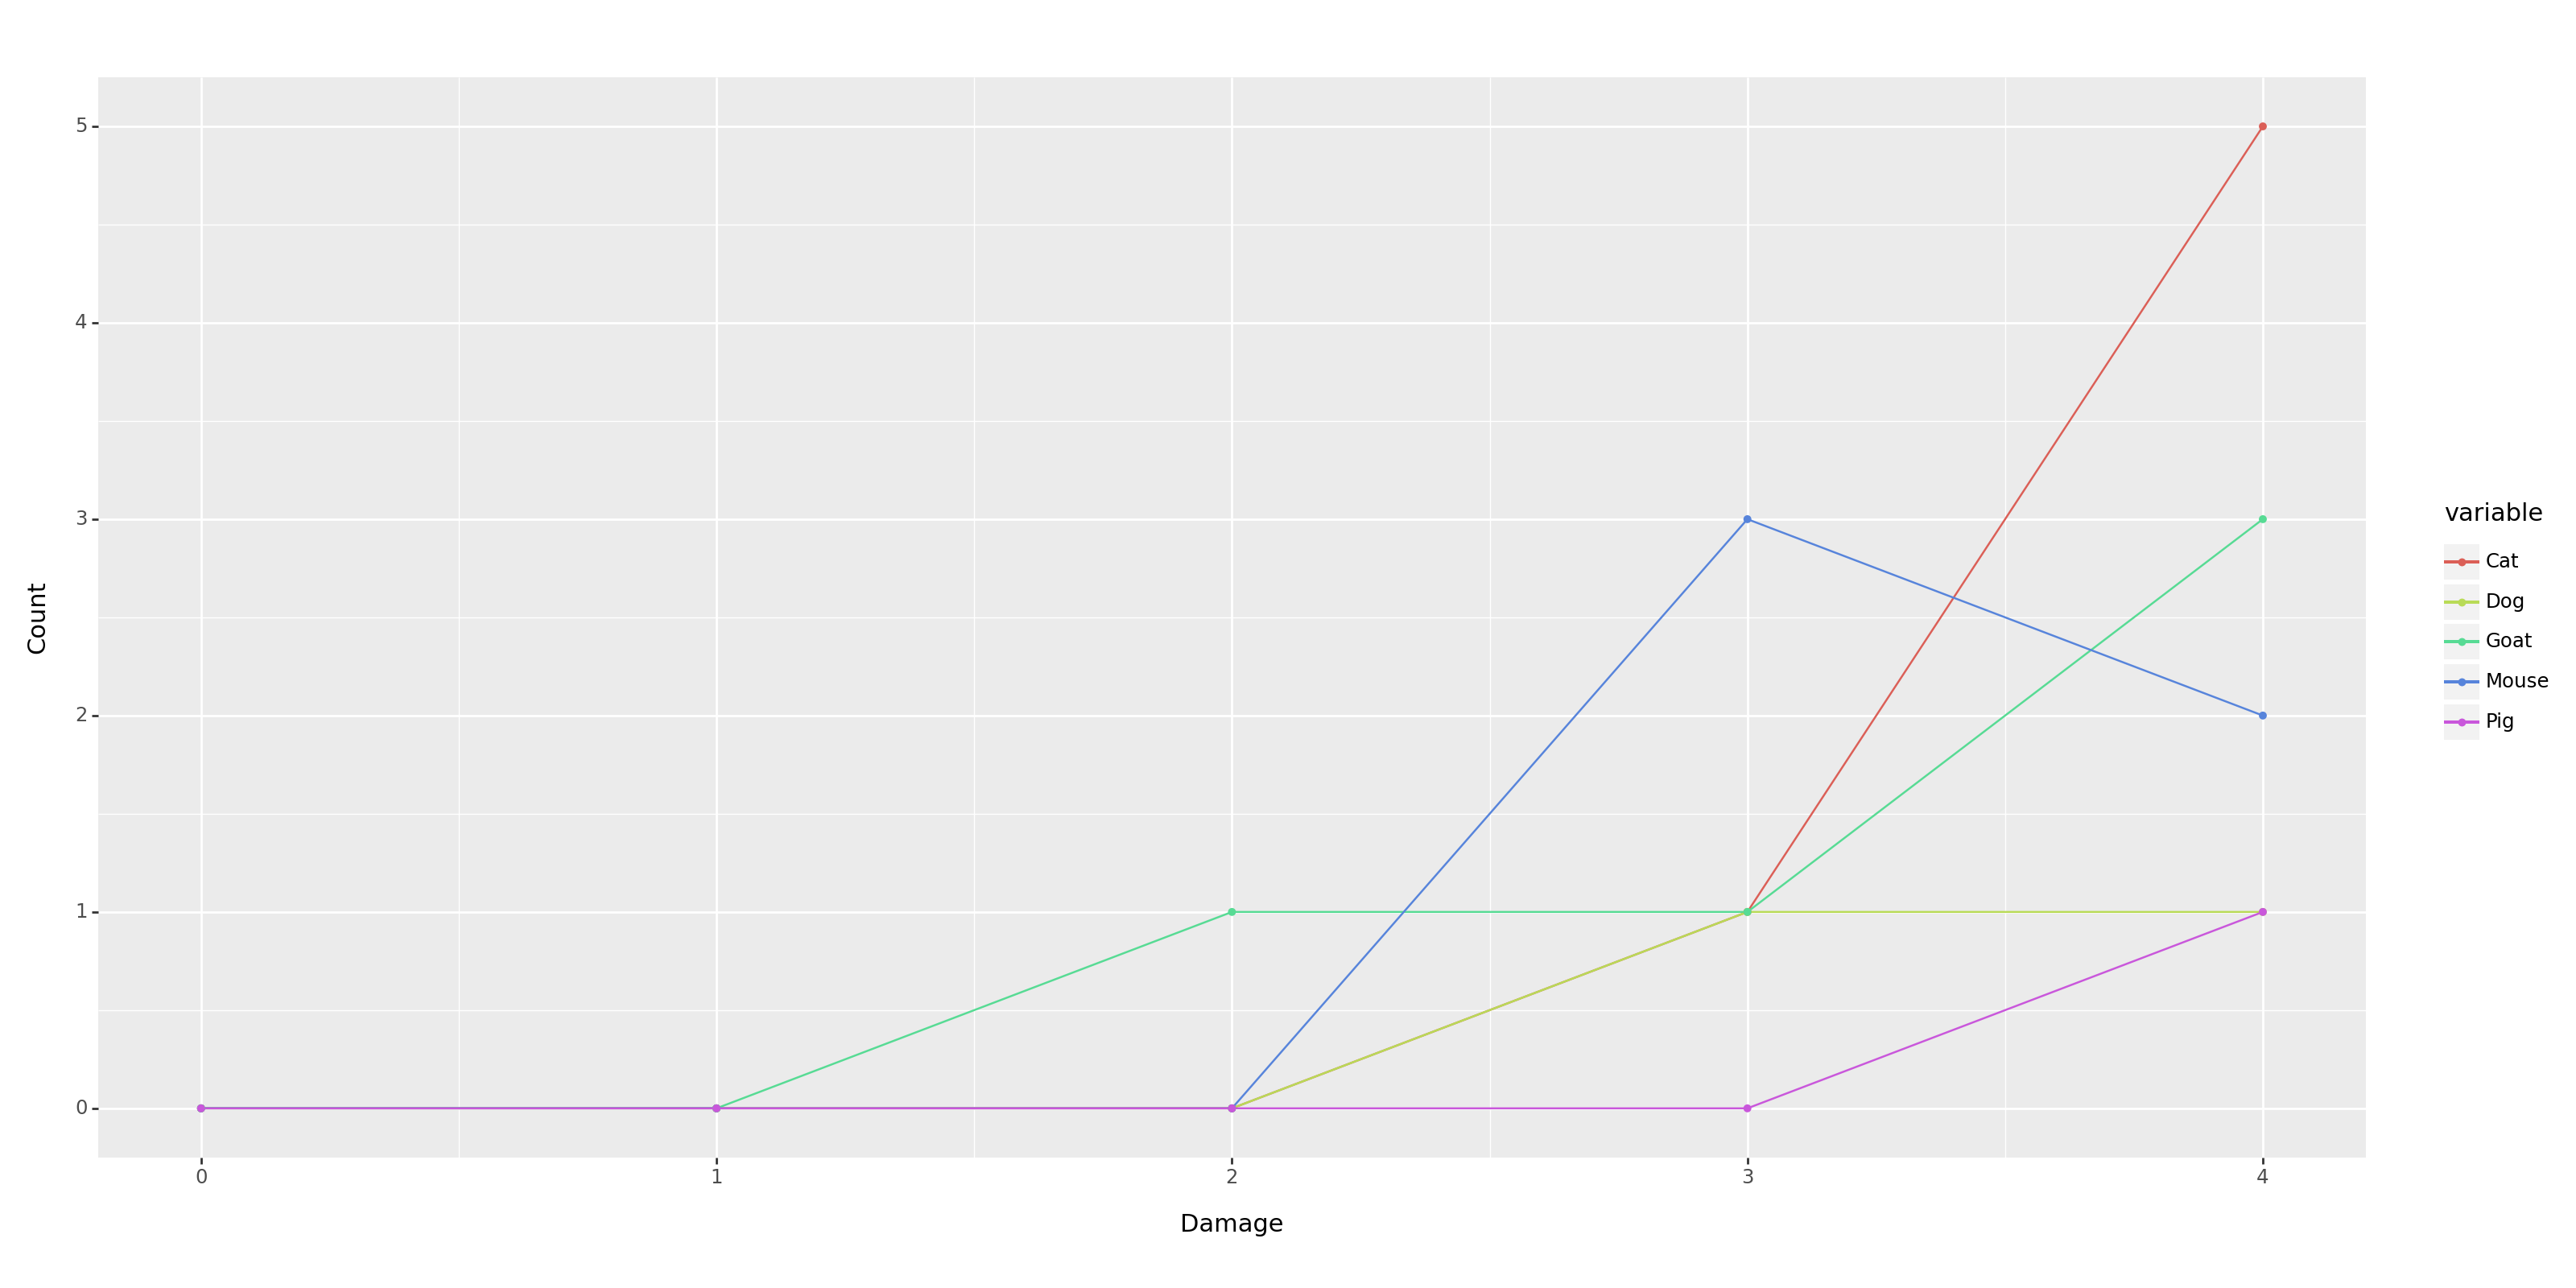

<Figure Size: (1600 x 800)>

In [103]:
sim_dementia_1x_diagram = (ggplot(sim_dementia_final_results_1x_all, mapping=aes(x="Damage", y="Count", color="variable"))+
                           geom_line()+
                           geom_point(size=1)+
                           labs(caption = "")+
                           theme(figure_size=(16,8), plot_caption=element_text(hjust=0, size="16", lineheight=1.5)))
sim_dementia_1x_diagram

#### Simulating Dementia in Model Trained on 8x Dog Pattern Frequency

In [104]:
sim_dementia_model_8x = build_dementia_model()

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [105]:
fit_sim_dementia_model(sim_dementia_model_8x, appendix_full_table_8x)

5000/5000 [==============================] - 47s 9ms/step - loss: 1.8447e-04


In [106]:
sim_dementia_model_8x.save_weights('dementia_correct_weights_8x.h5')

In [107]:
# Clone the model
sim_dementia_model_8x_0 = clone_model(sim_dementia_model_8x)
sim_dementia_model_8x_0.set_weights(sim_dementia_model_8x.get_weights())

sim_dementia_model_8x_1 = clone_model(sim_dementia_model_8x)
sim_dementia_model_8x_1.set_weights(sim_dementia_model_8x.get_weights())

sim_dementia_model_8x_2 = clone_model(sim_dementia_model_8x)
sim_dementia_model_8x_2.set_weights(sim_dementia_model_8x.get_weights())

sim_dementia_model_8x_3 = clone_model(sim_dementia_model_8x)
sim_dementia_model_8x_3.set_weights(sim_dementia_model_8x.get_weights())

sim_dementia_model_8x_4 = clone_model(sim_dementia_model_8x)
sim_dementia_model_8x_4.set_weights(sim_dementia_model_8x.get_weights())

In [108]:
sim_dementia_results_8x_0 = simulate_damage_query(0.0, sim_dementia_model_8x_0, 'dementia_correct_weights_8x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_8x_0 = sim_dementia_results_8x_0.sort_values(by='Item')
sim_dementia_results_8x_0

sim_dementia_wrong_results_8x_0 = sim_dementia_results_8x_0[sim_dementia_results_8x_0["Item"] != sim_dementia_results_8x_0["variable"]]
sim_dementia_wrong_results_8x_0['Damage'] = 0
sim_dementia_wrong_results_8x_0

,Item,Relation,variable,value,Damage


In [109]:
sim_dementia_results_8x_1 = simulate_damage_query(1.0, sim_dementia_model_8x_1, 'dementia_correct_weights_8x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_8x_1 = sim_dementia_results_8x_1.sort_values(by='Item')
sim_dementia_results_8x_1

sim_dementia_wrong_results_8x_1 = sim_dementia_results_8x_1[sim_dementia_results_8x_1["Item"] != sim_dementia_results_8x_1["variable"]]
sim_dementia_wrong_results_8x_1['Damage'] = 1
sim_dementia_wrong_results_8x_1

,Item,Relation,variable,value,Damage


In [110]:
sim_dementia_results_8x_2 = simulate_damage_query(2.0, sim_dementia_model_8x_2, 'dementia_correct_weights_8x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_8x_2 = sim_dementia_results_8x_2.sort_values(by='Item')
sim_dementia_results_8x_2

sim_dementia_wrong_results_8x_2 = sim_dementia_results_8x_2[sim_dementia_results_8x_2["Item"] != sim_dementia_results_8x_2["variable"]]
sim_dementia_wrong_results_8x_2['Damage'] = 2
sim_dementia_wrong_results_8x_2

,Item,Relation,variable,value,Damage


In [111]:
sim_dementia_results_8x_3 = simulate_damage_query(3.0, sim_dementia_model_8x_3, 'dementia_correct_weights_8x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_8x_3 = sim_dementia_results_8x_3.sort_values(by='Item')
sim_dementia_results_8x_3

sim_dementia_wrong_results_8x_3 = sim_dementia_results_8x_3[sim_dementia_results_8x_3["Item"] != sim_dementia_results_8x_3["variable"]]
sim_dementia_wrong_results_8x_3['Damage'] = 3
sim_dementia_wrong_results_8x_3

<ipython-input-111-75bae589cdc6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Item,Relation,variable,value,Damage
33,Goat,ISA-BASIC,Cat,0.769442,3


In [112]:
sim_dementia_results_8x_4 = simulate_damage_query(4.0, sim_dementia_model_8x_4, 'dementia_correct_weights_8x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_8x_4 = sim_dementia_results_8x_4.sort_values(by='Item')
sim_dementia_results_8x_4

sim_dementia_wrong_results_8x_4 = sim_dementia_results_8x_4[sim_dementia_results_8x_4["Item"] != sim_dementia_results_8x_4["variable"]]
sim_dementia_wrong_results_8x_4['Damage'] = 4
sim_dementia_wrong_results_8x_4

<ipython-input-112-7cedac9fd024>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Item,Relation,variable,value,Damage
41,Dog,ISA-BASIC,Mouse,0.811430,4
33,Goat,ISA-BASIC,Cat,0.706439,4


In [113]:
sim_dementia_wrong_results_8x_all = pd.DataFrame()
sim_dementia_wrong_results_8x_all = pd.concat([sim_dementia_wrong_results_8x_all, sim_dementia_wrong_results_8x_0])
sim_dementia_wrong_results_8x_all = pd.concat([sim_dementia_wrong_results_8x_all, sim_dementia_wrong_results_8x_1])
sim_dementia_wrong_results_8x_all = pd.concat([sim_dementia_wrong_results_8x_all, sim_dementia_wrong_results_8x_2])
sim_dementia_wrong_results_8x_all = pd.concat([sim_dementia_wrong_results_8x_all, sim_dementia_wrong_results_8x_3])
sim_dementia_wrong_results_8x_all = pd.concat([sim_dementia_wrong_results_8x_all, sim_dementia_wrong_results_8x_4])

sim_dementia_wrong_results_8x_all = sim_dementia_wrong_results_8x_all.groupby(['variable', 'Damage'], sort=False).size().reset_index(name='Count')
sim_dementia_wrong_results_8x_all

,variable,Damage,Count
0,Cat,3,1
1,Mouse,4,1
2,Cat,4,1


In [114]:
sim_dementia_final_results_8x_structure = {'variable': np.tile(mammal_item_names, 5), 'Damage': np.repeat([0, 1, 2, 3, 4], 5)}
sim_dementia_final_results_8x_structure['Count'] = 0
sim_dementia_final_results_8x_all = pd.DataFrame(data=sim_dementia_final_results_8x_structure)
sim_dementia_final_results_8x_all

for row in sim_dementia_wrong_results_8x_all.itertuples(index=False):
    variable = row[0]
    damage = row[1]
    value_to_update = row[2]

    # Find the row in sim_dementia_final_results_8x_all where 'variable' matches and 'Damage' matches
    mask = (sim_dementia_final_results_8x_all['variable'] == variable) & (sim_dementia_final_results_8x_all['Damage'] == damage)

    # Update the 'Count' column with the new value
    sim_dementia_final_results_8x_all.loc[mask, 'Count'] = value_to_update

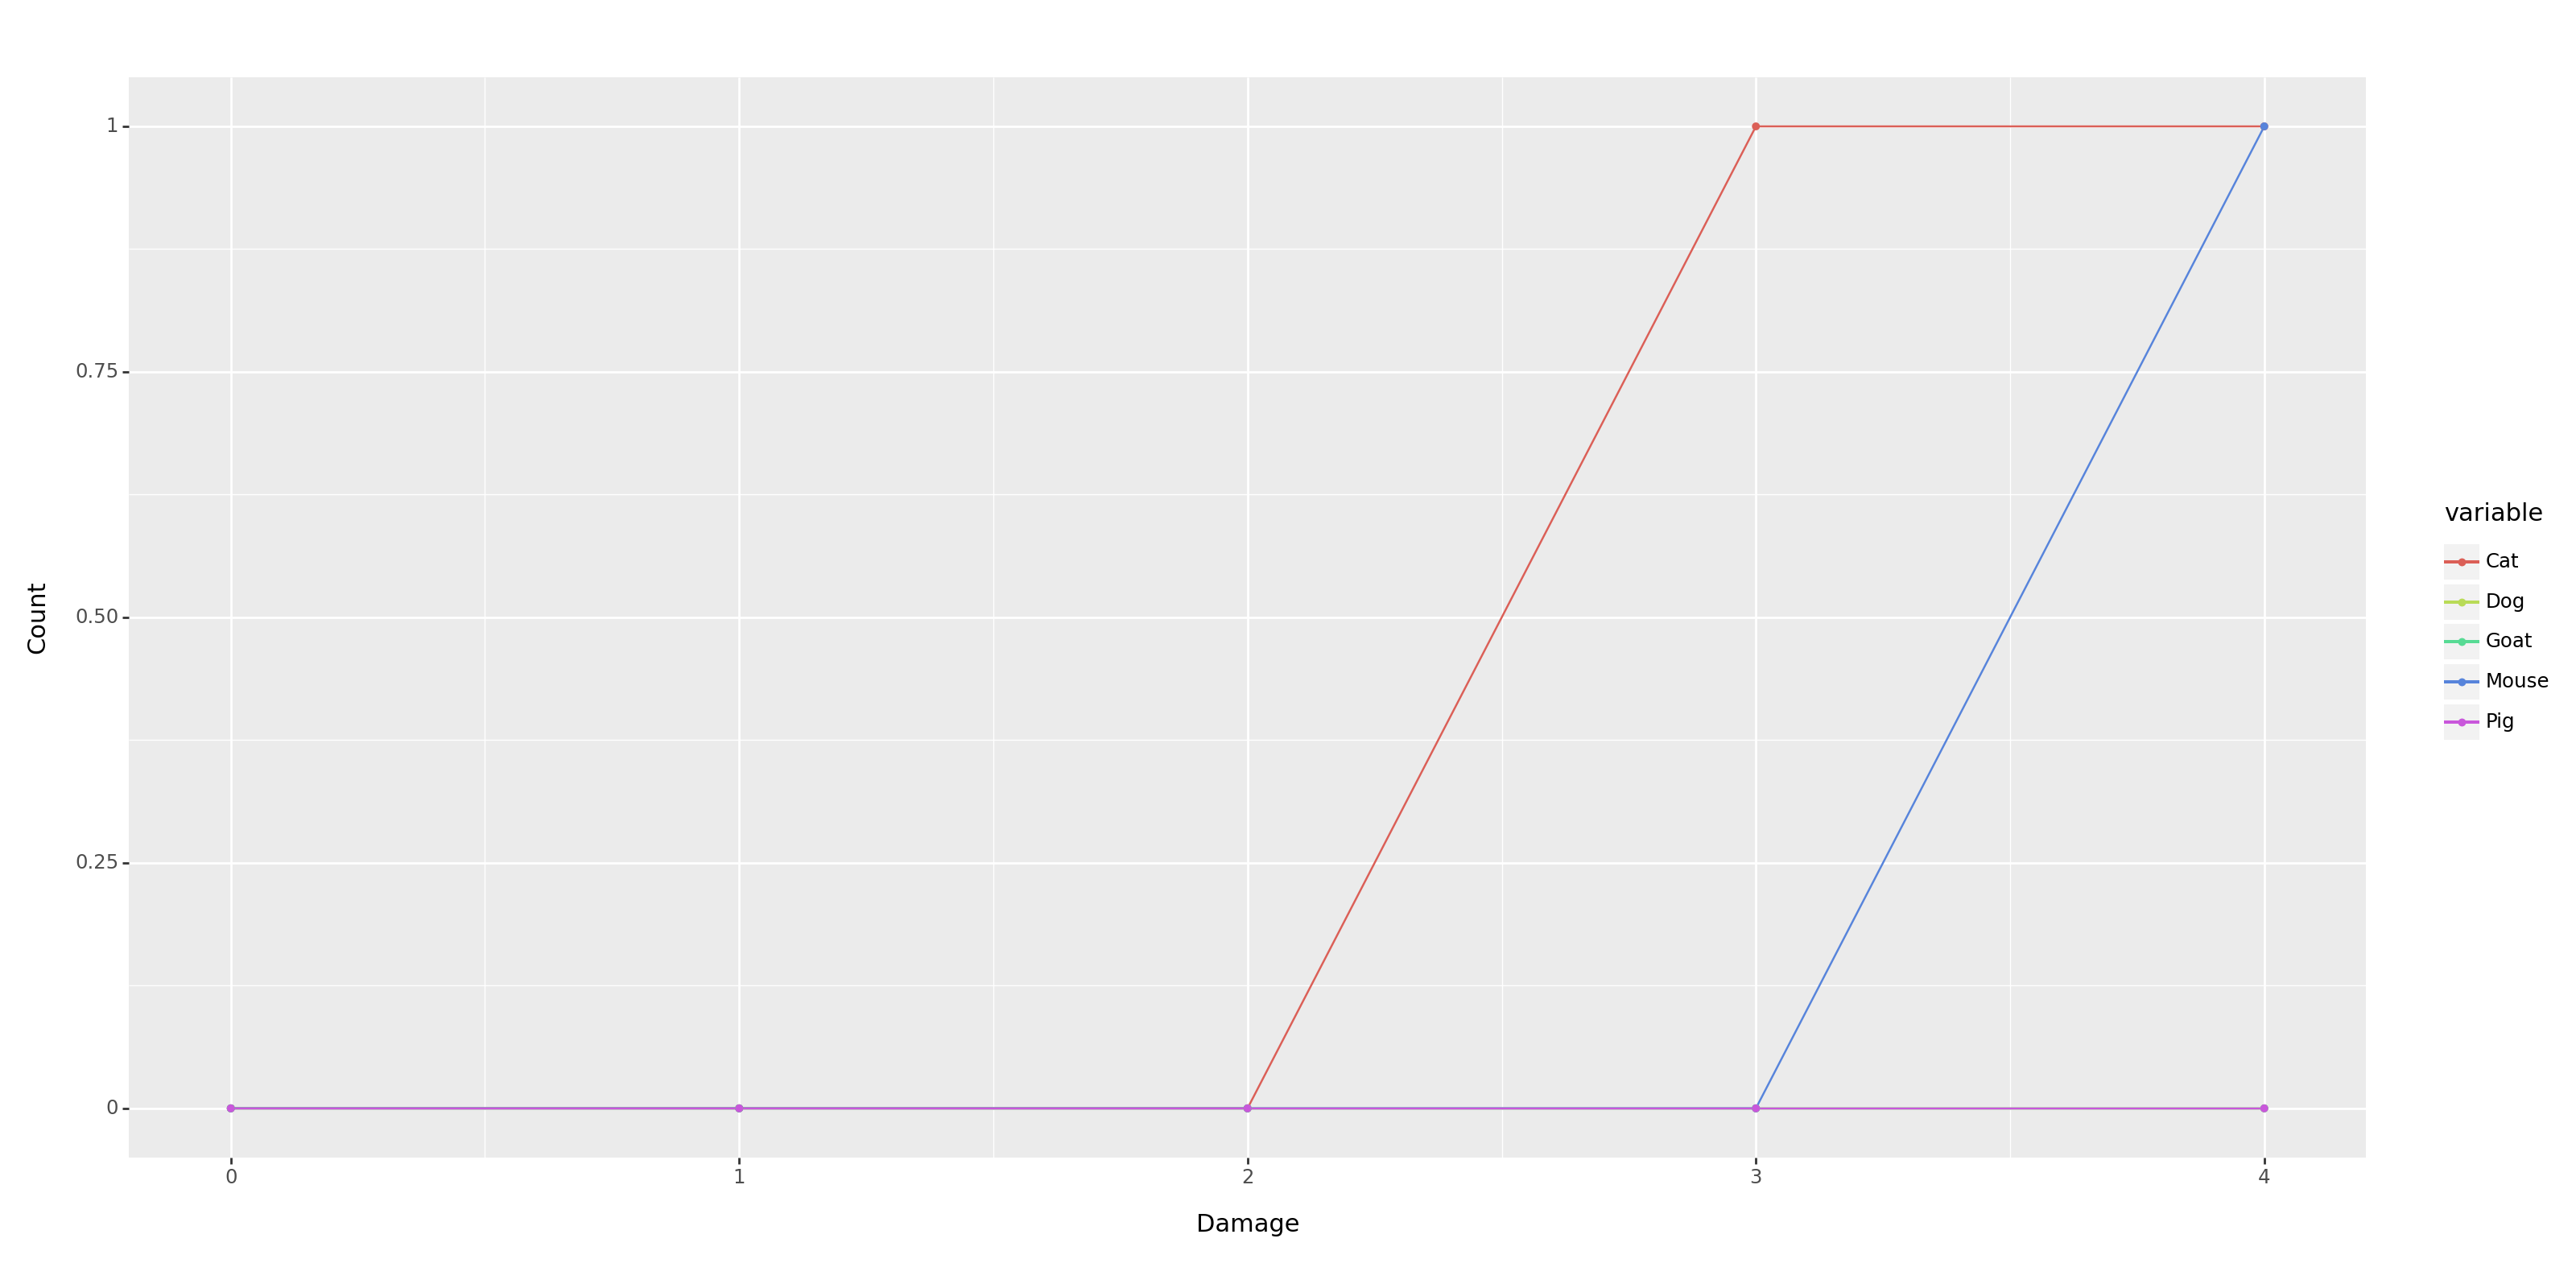

<Figure Size: (1600 x 800)>

In [115]:
sim_dementia_8x_diagram = (ggplot(sim_dementia_final_results_8x_all, mapping=aes(x="Damage", y="Count", color="variable"))+
                           geom_line()+
                           geom_point(size=1)+
                           labs(caption = "")+
                           theme(figure_size=(16,8), plot_caption=element_text(hjust=0, size="16", lineheight=1.5)))
sim_dementia_8x_diagram

#### Simulating Dementia in Model Trained on 16x Dog Pattern Frequency

In [116]:
sim_dementia_model_16x = build_dementia_model()
fit_sim_dementia_model(sim_dementia_model_16x, appendix_full_table_16x)
sim_dementia_model_16x.save_weights('dementia_correct_weights_16x.h5')

# Clone the model
sim_dementia_model_16x_0 = clone_model(sim_dementia_model_16x)
sim_dementia_model_16x_0.set_weights(sim_dementia_model_16x.get_weights())

sim_dementia_model_16x_1 = clone_model(sim_dementia_model_16x)
sim_dementia_model_16x_1.set_weights(sim_dementia_model_16x.get_weights())

sim_dementia_model_16x_2 = clone_model(sim_dementia_model_16x)
sim_dementia_model_16x_2.set_weights(sim_dementia_model_16x.get_weights())

sim_dementia_model_16x_3 = clone_model(sim_dementia_model_16x)
sim_dementia_model_16x_3.set_weights(sim_dementia_model_16x.get_weights())

sim_dementia_model_16x_4 = clone_model(sim_dementia_model_16x)
sim_dementia_model_16x_4.set_weights(sim_dementia_model_16x.get_weights())

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


5000/5000 [==============================] - 52s 10ms/step - loss: 1.5416e-04


<ipython-input-117-ae102831594f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-117-ae102831594f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-117-ae102831594f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


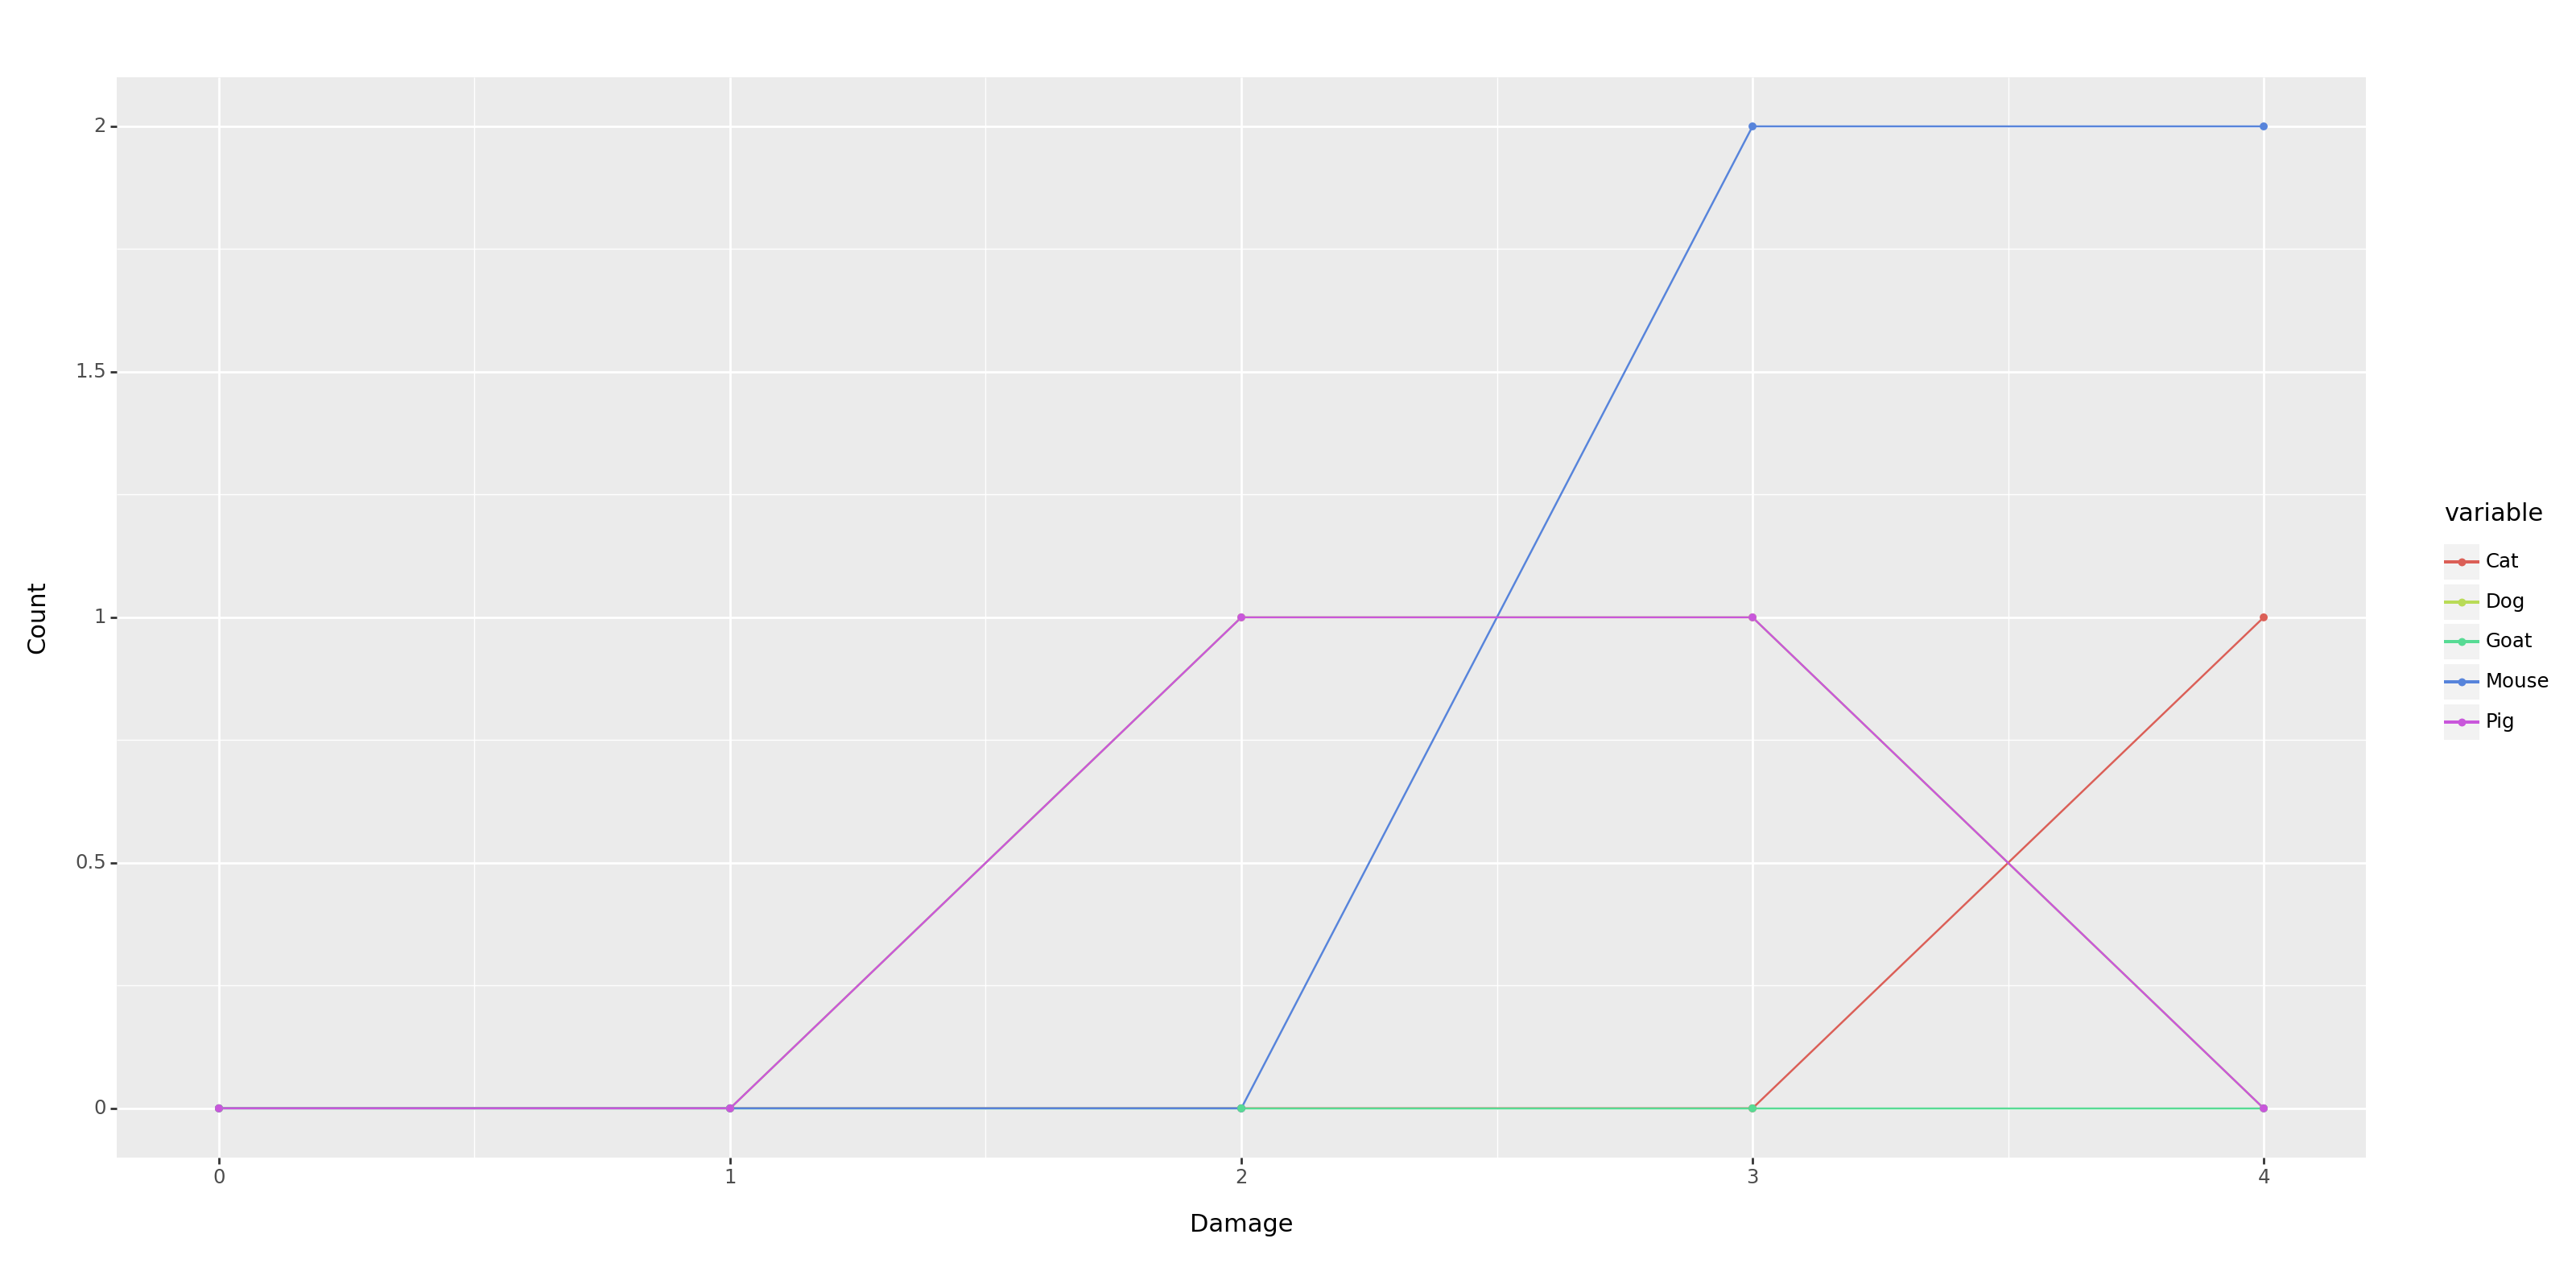

<Figure Size: (1600 x 800)>

In [117]:

sim_dementia_results_16x_0 = simulate_damage_query(0.0, sim_dementia_model_16x_0, 'dementia_correct_weights_16x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_16x_0 = sim_dementia_results_16x_0.sort_values(by='Item')
sim_dementia_results_16x_0

sim_dementia_wrong_results_16x_0 = sim_dementia_results_16x_0[sim_dementia_results_16x_0["Item"] != sim_dementia_results_16x_0["variable"]]
sim_dementia_wrong_results_16x_0['Damage'] = 0
sim_dementia_wrong_results_16x_0

sim_dementia_results_16x_1 = simulate_damage_query(1.0, sim_dementia_model_16x_1, 'dementia_correct_weights_16x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_16x_1 = sim_dementia_results_16x_1.sort_values(by='Item')
sim_dementia_results_16x_1

sim_dementia_wrong_results_16x_1 = sim_dementia_results_16x_1[sim_dementia_results_16x_1["Item"] != sim_dementia_results_16x_1["variable"]]
sim_dementia_wrong_results_16x_1['Damage'] = 1
sim_dementia_wrong_results_16x_1

sim_dementia_results_16x_2 = simulate_damage_query(2.0, sim_dementia_model_16x_2, 'dementia_correct_weights_16x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_16x_2 = sim_dementia_results_16x_2.sort_values(by='Item')
sim_dementia_results_16x_2

sim_dementia_wrong_results_16x_2 = sim_dementia_results_16x_2[sim_dementia_results_16x_2["Item"] != sim_dementia_results_16x_2["variable"]]
sim_dementia_wrong_results_16x_2['Damage'] = 2
sim_dementia_wrong_results_16x_2

sim_dementia_results_16x_3 = simulate_damage_query(3.0, sim_dementia_model_16x_3, 'dementia_correct_weights_16x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_16x_3 = sim_dementia_results_16x_3.sort_values(by='Item')
sim_dementia_results_16x_3

sim_dementia_wrong_results_16x_3 = sim_dementia_results_16x_3[sim_dementia_results_16x_3["Item"] != sim_dementia_results_16x_3["variable"]]
sim_dementia_wrong_results_16x_3['Damage'] = 3
sim_dementia_wrong_results_16x_3

sim_dementia_results_16x_4 = simulate_damage_query(4.0, sim_dementia_model_16x_4, 'dementia_correct_weights_16x.h5', x_dementia_query_items, x_dementia_query_relations, 50)
sim_dementia_results_16x_4 = sim_dementia_results_16x_4.sort_values(by='Item')
sim_dementia_results_16x_4

sim_dementia_wrong_results_16x_4 = sim_dementia_results_16x_4[sim_dementia_results_16x_4["Item"] != sim_dementia_results_16x_4["variable"]]
sim_dementia_wrong_results_16x_4['Damage'] = 4
sim_dementia_wrong_results_16x_4

sim_dementia_wrong_results_16x_all = pd.DataFrame()
sim_dementia_wrong_results_16x_all = pd.concat([sim_dementia_wrong_results_16x_all, sim_dementia_wrong_results_16x_0])
sim_dementia_wrong_results_16x_all = pd.concat([sim_dementia_wrong_results_16x_all, sim_dementia_wrong_results_16x_1])
sim_dementia_wrong_results_16x_all = pd.concat([sim_dementia_wrong_results_16x_all, sim_dementia_wrong_results_16x_2])
sim_dementia_wrong_results_16x_all = pd.concat([sim_dementia_wrong_results_16x_all, sim_dementia_wrong_results_16x_3])
sim_dementia_wrong_results_16x_all = pd.concat([sim_dementia_wrong_results_16x_all, sim_dementia_wrong_results_16x_4])

sim_dementia_wrong_results_16x_all = sim_dementia_wrong_results_16x_all.groupby(['variable', 'Damage'], sort=False).size().reset_index(name='Count')
sim_dementia_wrong_results_16x_all

sim_dementia_final_results_16x_structure = {'variable': np.tile(mammal_item_names, 5), 'Damage': np.repeat([0, 1, 2, 3, 4], 5)}
sim_dementia_final_results_16x_structure['Count'] = 0
sim_dementia_final_results_16x_all = pd.DataFrame(data=sim_dementia_final_results_16x_structure)
sim_dementia_final_results_16x_all

for row in sim_dementia_wrong_results_16x_all.itertuples(index=False):
    variable = row[0]
    damage = row[1]
    value_to_update = row[2]

    # Find the row in sim_dementia_final_results_16x_all where 'variable' matches and 'Damage' matches
    mask = (sim_dementia_final_results_16x_all['variable'] == variable) & (sim_dementia_final_results_16x_all['Damage'] == damage)

    # Update the 'Count' column with the new value
    sim_dementia_final_results_16x_all.loc[mask, 'Count'] = value_to_update

sim_dementia_16x_diagram = (ggplot(sim_dementia_final_results_16x_all, mapping=aes(x="Damage", y="Count", color="variable"))+
                           geom_line()+
                           geom_point(size=1)+
                           labs(caption = "")+
                           theme(figure_size=(16,8), plot_caption=element_text(hjust=0, size="16", lineheight=1.5)))
sim_dementia_16x_diagram

### Simulate Representation Moving From "Dog" to "Cat" Under Different Dog Pattern Training Frequencies

#### Make Inference Models from Original Development Model and 8x Version

Josh: Is there a difference between cloning the model and extracting the Representation layer as needed, vs. building a new model that strips away the hidden, relation and output layers and keeps only item, onehot and representation? Here I feel like the first approach could be close to original, but I also didn't know what the RELATION input would be, so I chose to go with the second approach.
...and then i went with the first cuz I realized we need the name activation values, but now I don't know what to do with the relation thing

In [118]:
sim_development_model_rep_0x = tf.keras.models.Model(inputs=sim_development_model.get_layer('Item_Input').input, outputs=sim_development_model.get_layer('Representation').output)
sim_development_model_rep_8x = tf.keras.models.Model(inputs=sim_development_model_8x.get_layer('Item_Input').input, outputs=sim_development_model_8x.get_layer('Representation').output)

#### Run Prediction for Each Mammal and Save

In [119]:
# 0x model representation pattern for each mammal
mammal_representation_df_0x = sim_development_model_rep_0x(mammal_item_names)
mammal_representation_df_0x = pd.DataFrame(mammal_representation_df_0x)
mammal_representation_df_0x.insert(0, 'Item', mammal_item_names)
mammal_representation_df_0x

,Item,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Cat,0.993130,0.489973,0.809994,0.476093,0.990793,0.160968,0.990398,0.970460,0.989263,0.005807,0.570222,0.014489,0.820743,0.006948,0.117585
1,Dog,0.329663,0.971384,0.997694,0.971785,0.108858,0.008400,0.009542,0.988862,0.914769,0.058433,0.546343,0.002124,0.988107,0.013947,0.551297
2,Mouse,0.096600,0.032833,0.990542,0.993014,0.950568,0.148993,0.008409,0.974031,0.984513,0.013688,0.135282,0.026801,0.787858,0.291091,0.019824
3,Goat,0.995545,0.981454,0.727386,0.997629,0.919033,0.528471,0.008415,0.990063,0.994914,0.017162,0.005292,0.132853,0.201246,0.010306,0.250497
4,Pig,0.942490,0.174658,0.983225,0.857095,0.992088,0.015992,0.003665,0.991928,0.386073,0.980635,0.843122,0.009560,0.211924,0.009883,0.973314


In [120]:
# 8x model representation pattern for each mammal
mammal_representation_df_8x = sim_development_model_rep_8x(mammal_item_names)
mammal_representation_df_8x = pd.DataFrame(mammal_representation_df_8x)
mammal_representation_df_8x.insert(0, 'Item', mammal_item_names)
mammal_representation_df_8x

,Item,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Cat,0.012155,0.964722,0.011066,0.988946,0.039247,0.790319,0.290448,0.986135,0.745049,0.006277,0.006211,0.083190,0.600378,0.944747,0.467572
1,Dog,0.841870,0.072688,0.041737,0.031441,0.126768,0.992314,0.250086,0.987522,0.856150,0.012376,0.278485,0.020583,0.995820,0.875024,0.011893
2,Mouse,0.010516,0.988895,0.823208,0.271628,0.617965,0.997717,0.900272,0.881984,0.208206,0.040425,0.101077,0.017865,0.851383,0.314199,0.090506
3,Goat,0.160808,0.388506,0.236766,0.986293,0.005648,0.968235,0.995162,0.989725,0.700605,0.930161,0.653898,0.003828,0.995181,0.816153,0.014221
4,Pig,0.012089,0.446187,0.515464,0.178877,0.006079,0.996401,0.982914,0.037692,0.943946,0.003111,0.678036,0.916927,0.990966,0.994729,0.017679


#### Get Relation Layer Output for ISA-BASIC

In [121]:
appendix_relation_names[2]

'ISA-BASIC'

In [122]:
sim_development_relation_model_input_layer_0x = tf.keras.layers.Input(shape=(1,), name="Relation_Input", dtype="string")
sim_development_relation_model_output_layer_0x = tf.keras.layers.StringLookup(name="Relation_OneHot", vocabulary=appendix_relation_names, num_oov_indices=0, output_mode="one_hot")(sim_development_relation_model_input_layer_0x)

sim_development_model_relation_0x = tf.keras.Model(inputs=sim_development_relation_model_input_layer_0x, outputs=sim_development_relation_model_output_layer_0x)

In [123]:
sim_development_relation_model_input_layer_8x = tf.keras.layers.Input(1, name="Relation_Input", dtype="string")
sim_development_relation_model_output_layer_8x = tf.keras.layers.StringLookup(name="Relation_OneHot", vocabulary=appendix_relation_names, num_oov_indices=0, output_mode="one_hot")(sim_development_relation_model_input_layer_8x)

sim_development_model_relation_8x = tf.keras.Model(inputs=sim_development_relation_model_input_layer_8x, outputs=sim_development_relation_model_output_layer_8x)

In [124]:
ISA_BASIC_representation_df_0x = sim_development_model_relation_0x.predict(['ISA-BASIC'])
ISA_BASIC_representation_df_0x = pd.DataFrame(ISA_BASIC_representation_df_0x)

1/1 [==============================] - 0s 86ms/step


In [125]:
ISA_BASIC_representation_df_8x = sim_development_model_relation_8x.predict(['ISA-BASIC'])
ISA_BASIC_representation_df_8x = pd.DataFrame(ISA_BASIC_representation_df_8x)

1/1 [==============================] - 0s 98ms/step


#### Make Inference Model to Interpolate Representations

In [126]:
sim_development_model_interpolate_0x = tf.keras.models.Model(inputs=sim_development_model.get_layer('Merge').input, outputs=sim_development_model.get_layer('Output').output)
sim_development_model_interpolate_8x = tf.keras.models.Model(inputs=sim_development_model_8x.get_layer('Merge').input, outputs=sim_development_model_8x.get_layer('Output').output)

tf.keras.utils.plot_model(
    sim_development_model_interpolate_0x,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True
)

sim_development_model_interpolate_0x.summary()
sim_development_model_interpolate_8x.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 15)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 Merge (Concatenate)         (None, 21)                   0         ['input_4[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 Hidden (Dense)              (None, 28)                   616       ['Merge[1][0]']         

#### Define Function for Interpolating Representations

In [127]:
def sim_development_interpolate_representations(development_model, familiar_mammal_name, target_mammal_name, familiar_pattern_rep, target_pattern_rep, relation_input, num_steps):
    results = pd.DataFrame()

    for step in range(num_steps):
        interpolated_rep = familiar_pattern_rep * ((num_steps - step)/num_steps) + target_pattern_rep * (step/num_steps)

        print(interpolated_rep.shape)
        # Make a prediction with the altered representation
        rep_prediction = development_model.predict([interpolated_rep, relation_input])

        result_activations = pd.DataFrame(rep_prediction, columns=appendix_attributes)
        result_activations['Step'] = step
        results = pd.concat([results, result_activations])

    return results[['Step', familiar_mammal_name, target_mammal_name]]

#         # Linear interpolation
#         interpolated_rep = current_rep + (step / num_steps) * (next_rep - current_rep)
#         interpolated_mammal_representations.append(interpolated_rep)

#     # Add the mouse representation at the end
#     interpolated_mammal_representations.append(representation_mouse)

#     interpolated_representations.append(interpolated_mammal_representations)

# # Now, 'interpolated_representations' contains the intermediate representations for each step in the transition.


#### Run Interpolations for 0x Model

In [128]:
np.array(ISA_BASIC_representation_df_0x).reshape((1,6))

array([[0., 1., 0., 0., 0., 0.]], dtype=float32)

In [129]:
cat_rep_0x = np.array(mammal_representation_df_0x.iloc[0,1:16], dtype="float32").reshape(1,-1)
dog_rep_0x = np.array(mammal_representation_df_0x.iloc[1,1:16], dtype="float32").reshape(1,-1)
mouse_rep_0x = np.array(mammal_representation_df_0x.iloc[2,1:16], dtype="float32").reshape(1,-1)
goat_rep_0x = np.array(mammal_representation_df_0x.iloc[3,1:16], dtype="float32").reshape(1,-1)
pig_rep_0x = np.array(mammal_representation_df_0x.iloc[4,1:16], dtype="float32").reshape(1,-1)

In [130]:
sim_cat_0x = sim_development_interpolate_representations(sim_development_model_interpolate_0x, 'Dog', 'Cat', dog_rep_0x, cat_rep_0x, np.array(ISA_BASIC_representation_df_0x).reshape((1,6)), 50)

(1, 15)
1/1 [==============================] - 0s 66ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 20ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 29ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 20ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [===========================

In [131]:
sim_cat_0x = sim_cat_0x.rename(columns={"Dog": "Dog(sim_cat)"})

In [132]:
sim_mouse_0x = sim_development_interpolate_representations(sim_development_model_interpolate_0x, 'Dog', 'Mouse', dog_rep_0x, mouse_rep_0x, np.array(ISA_BASIC_representation_df_0x).reshape((1,6)), 50)

(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 20ms/step
(1, 15)
1/1 [==============================] - 0s 25ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [===========================

In [133]:
sim_mouse_0x = sim_mouse_0x.rename(columns={"Dog": "Dog(sim_mouse)"})

In [134]:
sim_goat_0x = sim_development_interpolate_representations(sim_development_model_interpolate_0x, 'Dog', 'Goat', dog_rep_0x, goat_rep_0x, np.array(ISA_BASIC_representation_df_0x).reshape((1,6)), 50)

(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [==============================] - 0s 25ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 46ms/step
(1, 15)
1/1 [==============================] - 0s 33ms/step
(1, 15)
1/1 [==============================] - 0s 41ms/step
(1, 15)
1/1 [==============================] - 0s 31ms/step
(1, 15)
1/1 [==============================] - 0s 34ms/step
(1, 15)
1/1 [==============================] - 0s 34ms/step
(1, 15)
1/1 [==============================] - 0s 34ms/step
(1, 15)
1/1 [==============================] - 0s 35ms/step
(1, 15)
1/1 [==============================] - 0s 39ms/step
(1, 15)
1/1 [==============================] - 0s 33ms/step
(1, 15)
1/1 [==============================] - 0s 45ms/step
(1, 15)
1/1 [==============================] - 0s 44ms/step
(1, 15)
1/1 [==============================] - 0s 31ms/step
(1, 15)
1/1 [===========================

In [135]:
sim_goat_0x = sim_goat_0x.rename(columns={"Dog": "Dog(sim_goat)"})

In [136]:
sim_pig_0x = sim_development_interpolate_representations(sim_development_model_interpolate_0x, 'Dog', 'Pig', dog_rep_0x, pig_rep_0x, np.array(ISA_BASIC_representation_df_0x).reshape((1,6)), 50)

(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 25ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [==============================] - 0s 20ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 31ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [===========================

In [137]:
sim_pig_0x = sim_pig_0x.rename(columns={"Dog": "Dog(sim_pig)"})

#### Plot Activations for Dog vs Other Mammals in Model Trained on 0x Dog Frequency

In [138]:
sim_interpolate_reps_dogs_0x = sim_cat_0x.merge(sim_mouse_0x, how='inner', on='Step')
sim_interpolate_reps_dogs_0x = sim_interpolate_reps_dogs_0x.merge(sim_goat_0x, how='inner', on='Step')
sim_interpolate_reps_dogs_0x = sim_interpolate_reps_dogs_0x.merge(sim_pig_0x, how='inner', on='Step')

sim_interpolate_reps_dogs_0x = pd.melt(sim_interpolate_reps_dogs_0x, id_vars=['Step'])
sim_interpolate_reps_dogs_0x

,Step,variable,value
0,0,Dog(sim_cat),0.915881
1,1,Dog(sim_cat),0.911720
2,2,Dog(sim_cat),0.907123
3,3,Dog(sim_cat),0.902040
4,4,Dog(sim_cat),0.896415
...,...,...,...
395,45,Pig,0.904629
396,46,Pig,0.909724
397,47,Pig,0.914256
398,48,Pig,0.918297


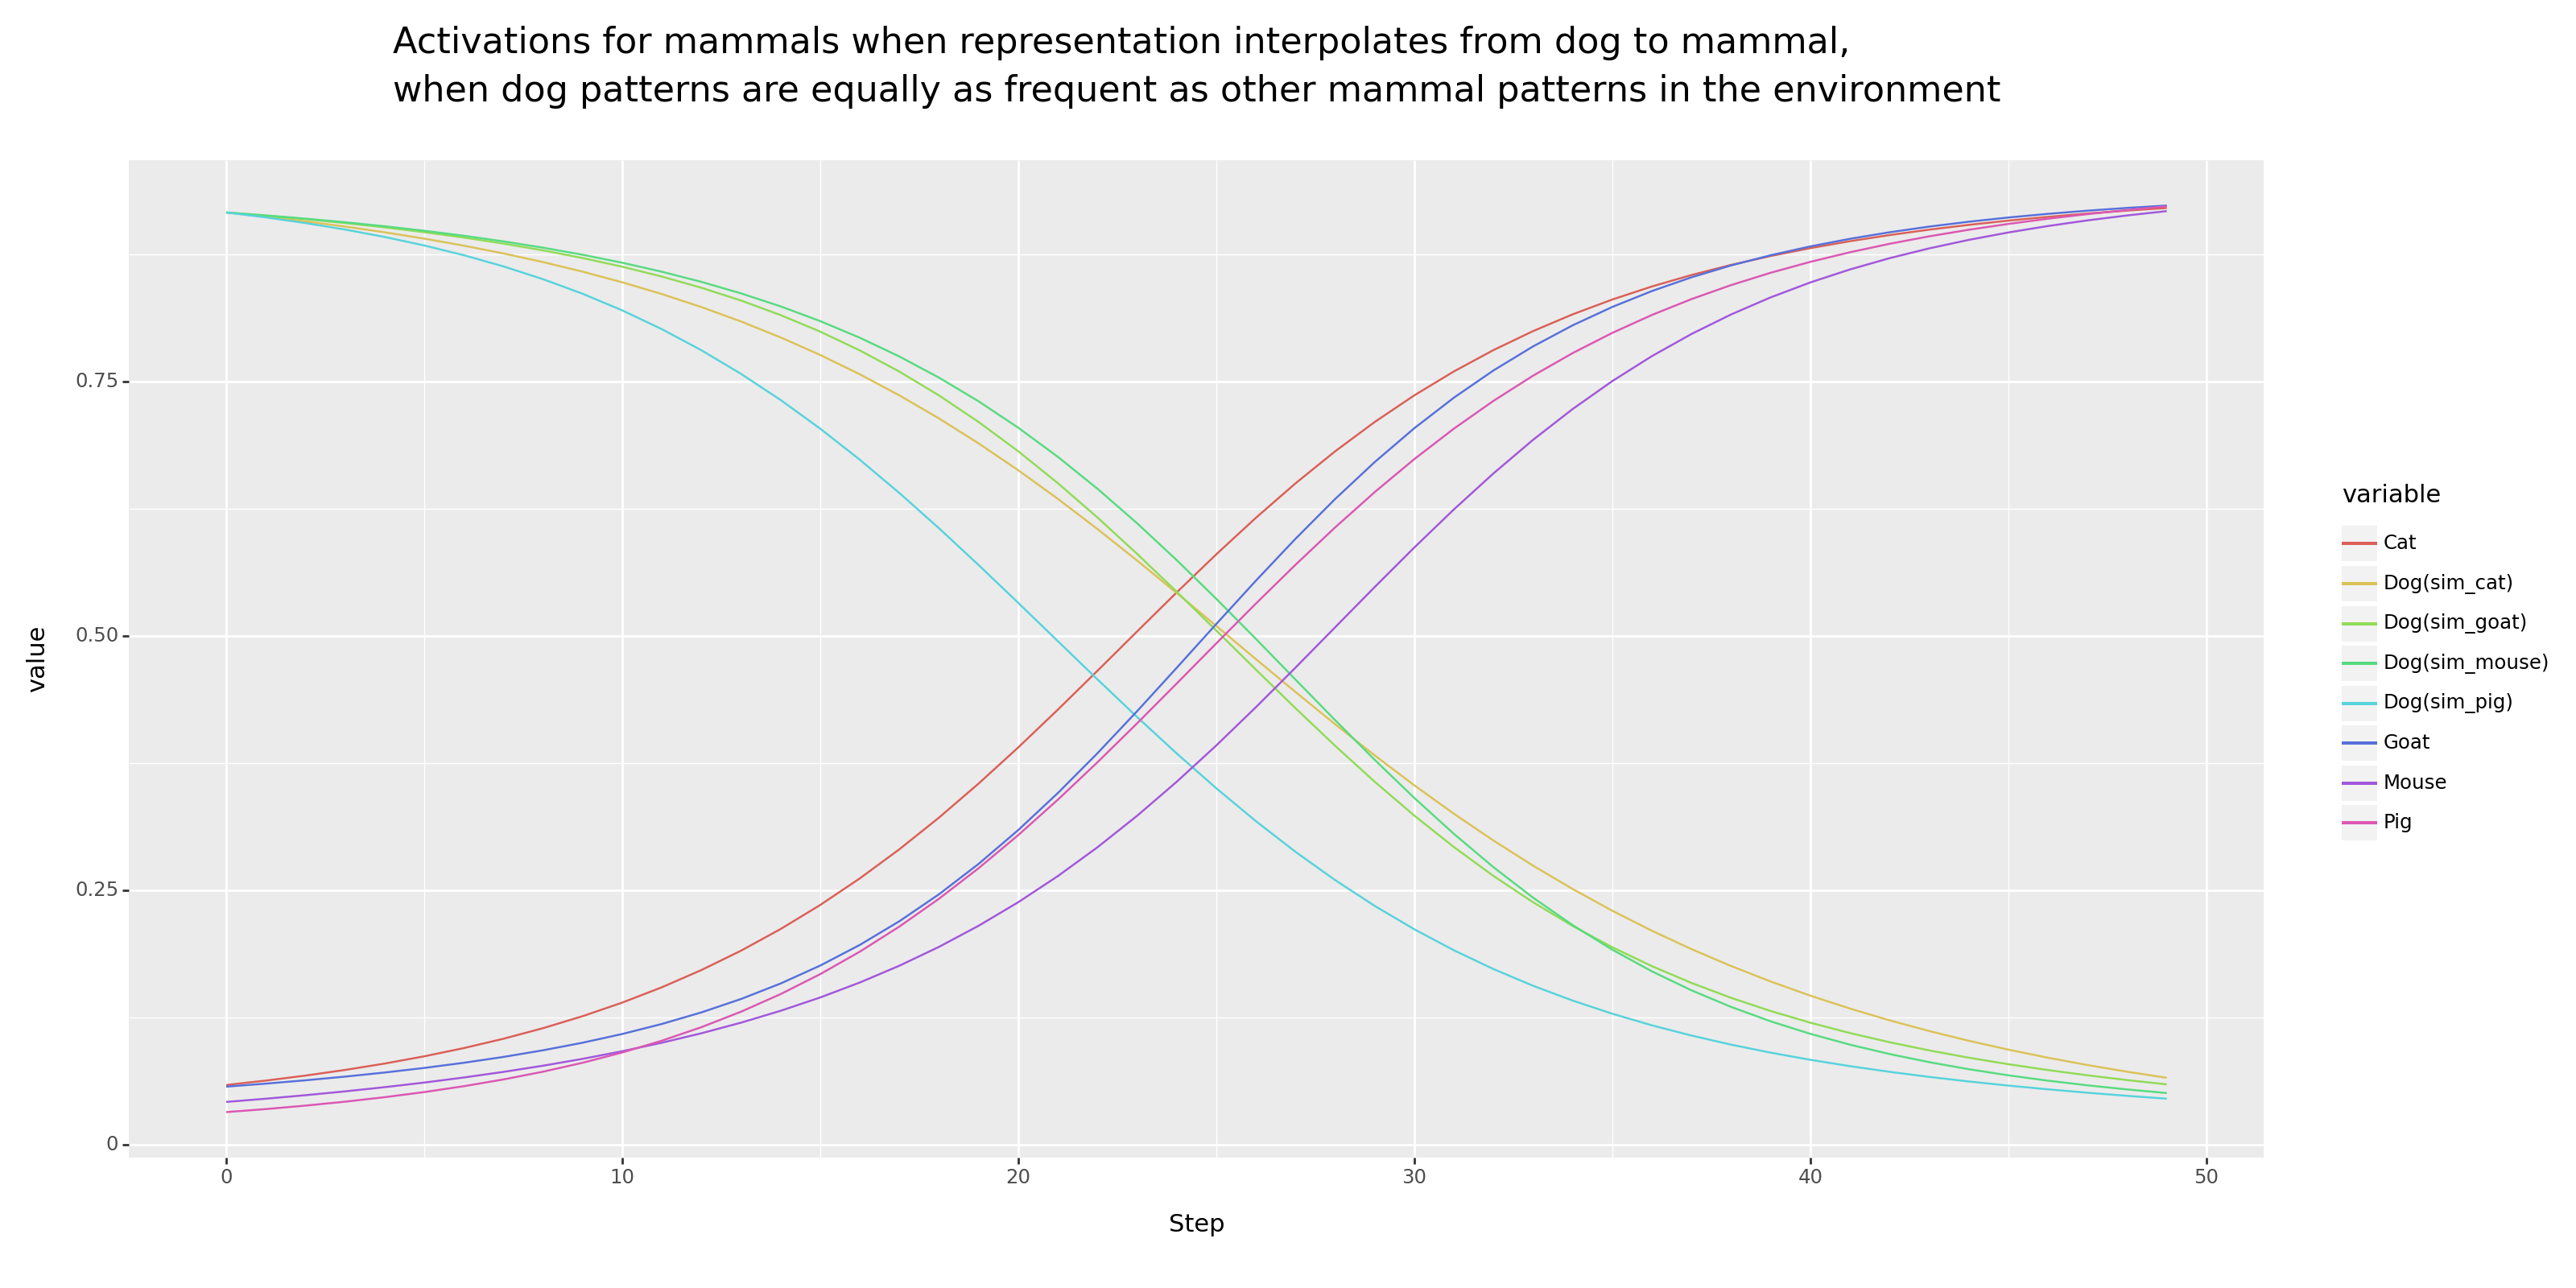

<Figure Size: (1600 x 800)>

In [139]:
sim_interpolate_reps_dogs_0x_diagram = (ggplot(sim_interpolate_reps_dogs_0x, mapping=aes(x="Step", y='value', color='variable'))+
                                        geom_line()+
                                        labs(title = "Activations for mammals when representation interpolates from dog to mammal,\nwhen dog patterns are equally as frequent as other mammal patterns in the environment")+
                                        theme(figure_size=(16,8), plot_title=element_text(hjust=0.5, size="16", lineheight=1.5)))
sim_interpolate_reps_dogs_0x_diagram

#### Run Interpolations for 8x Model

In [140]:
cat_rep_8x = np.array(mammal_representation_df_8x.iloc[0,1:16], dtype="float32").reshape(1,-1)
dog_rep_8x = np.array(mammal_representation_df_8x.iloc[1,1:16], dtype="float32").reshape(1,-1)
mouse_rep_8x = np.array(mammal_representation_df_8x.iloc[2,1:16], dtype="float32").reshape(1,-1)
goat_rep_8x = np.array(mammal_representation_df_8x.iloc[3,1:16], dtype="float32").reshape(1,-1)
pig_rep_8x = np.array(mammal_representation_df_8x.iloc[4,1:16], dtype="float32").reshape(1,-1)

In [141]:
sim_cat_8x = sim_development_interpolate_representations(sim_development_model_interpolate_8x, 'Dog', 'Cat', dog_rep_8x, cat_rep_8x, np.array(ISA_BASIC_representation_df_8x).reshape((1,6)), 50)
sim_cat_8x = sim_cat_8x.rename(columns={"Dog": "Dog(sim_cat)"})

(1, 15)
1/1 [==============================] - 0s 86ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 27ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 28ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [===========================

In [142]:
sim_mouse_8x = sim_development_interpolate_representations(sim_development_model_interpolate_8x, 'Dog', 'Mouse', dog_rep_8x, mouse_rep_8x, np.array(ISA_BASIC_representation_df_8x).reshape((1,6)), 50)
sim_mouse_8x = sim_mouse_8x.rename(columns={"Dog": "Dog(sim_mouse)"})

(1, 15)
1/1 [==============================] - 0s 32ms/step
(1, 15)
1/1 [==============================] - 0s 36ms/step
(1, 15)
1/1 [==============================] - 0s 48ms/step
(1, 15)
1/1 [==============================] - 0s 35ms/step
(1, 15)
1/1 [==============================] - 0s 32ms/step
(1, 15)
1/1 [==============================] - 0s 32ms/step
(1, 15)
1/1 [==============================] - 0s 40ms/step
(1, 15)
1/1 [==============================] - 0s 43ms/step
(1, 15)
1/1 [==============================] - 0s 32ms/step
(1, 15)
1/1 [==============================] - 0s 35ms/step
(1, 15)
1/1 [==============================] - 0s 36ms/step
(1, 15)
1/1 [==============================] - 0s 41ms/step
(1, 15)
1/1 [==============================] - 0s 38ms/step
(1, 15)
1/1 [==============================] - 0s 33ms/step
(1, 15)
1/1 [==============================] - 0s 35ms/step
(1, 15)
1/1 [==============================] - 0s 27ms/step
(1, 15)
1/1 [===========================

In [143]:
sim_goat_8x = sim_development_interpolate_representations(sim_development_model_interpolate_8x, 'Dog', 'Goat', dog_rep_8x, goat_rep_8x, np.array(ISA_BASIC_representation_df_8x).reshape((1,6)), 50)
sim_goat_8x = sim_goat_8x.rename(columns={"Dog": "Dog(sim_goat)"})

(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 27ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 27ms/step
(1, 15)
1/1 [==============================] - 0s 28ms/step
(1, 15)
1/1 [===========================

In [144]:
sim_pig_8x = sim_development_interpolate_representations(sim_development_model_interpolate_8x, 'Dog', 'Pig', dog_rep_8x, pig_rep_8x, np.array(ISA_BASIC_representation_df_8x).reshape((1,6)), 50)
sim_pig_8x = sim_pig_8x.rename(columns={"Dog": "Dog(sim_pig)"})

(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 22ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 25ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [==============================] - 0s 23ms/step
(1, 15)
1/1 [==============================] - 0s 21ms/step
(1, 15)
1/1 [==============================] - 0s 26ms/step
(1, 15)
1/1 [==============================] - 0s 24ms/step
(1, 15)
1/1 [===========================

In [145]:
sim_interpolate_reps_dogs_8x = sim_cat_8x.merge(sim_mouse_8x, how='inner', on='Step')
sim_interpolate_reps_dogs_8x = sim_interpolate_reps_dogs_8x.merge(sim_goat_8x, how='inner', on='Step')
sim_interpolate_reps_dogs_8x = sim_interpolate_reps_dogs_8x.merge(sim_pig_8x, how='inner', on='Step')

sim_interpolate_reps_dogs_8x = pd.melt(sim_interpolate_reps_dogs_8x, id_vars=['Step'])
sim_interpolate_reps_dogs_8x

,Step,variable,value
0,0,Dog(sim_cat),0.947122
1,1,Dog(sim_cat),0.943974
2,2,Dog(sim_cat),0.940383
3,3,Dog(sim_cat),0.936277
4,4,Dog(sim_cat),0.931571
...,...,...,...
395,45,Pig,0.890368
396,46,Pig,0.896234
397,47,Pig,0.901448
398,48,Pig,0.906100


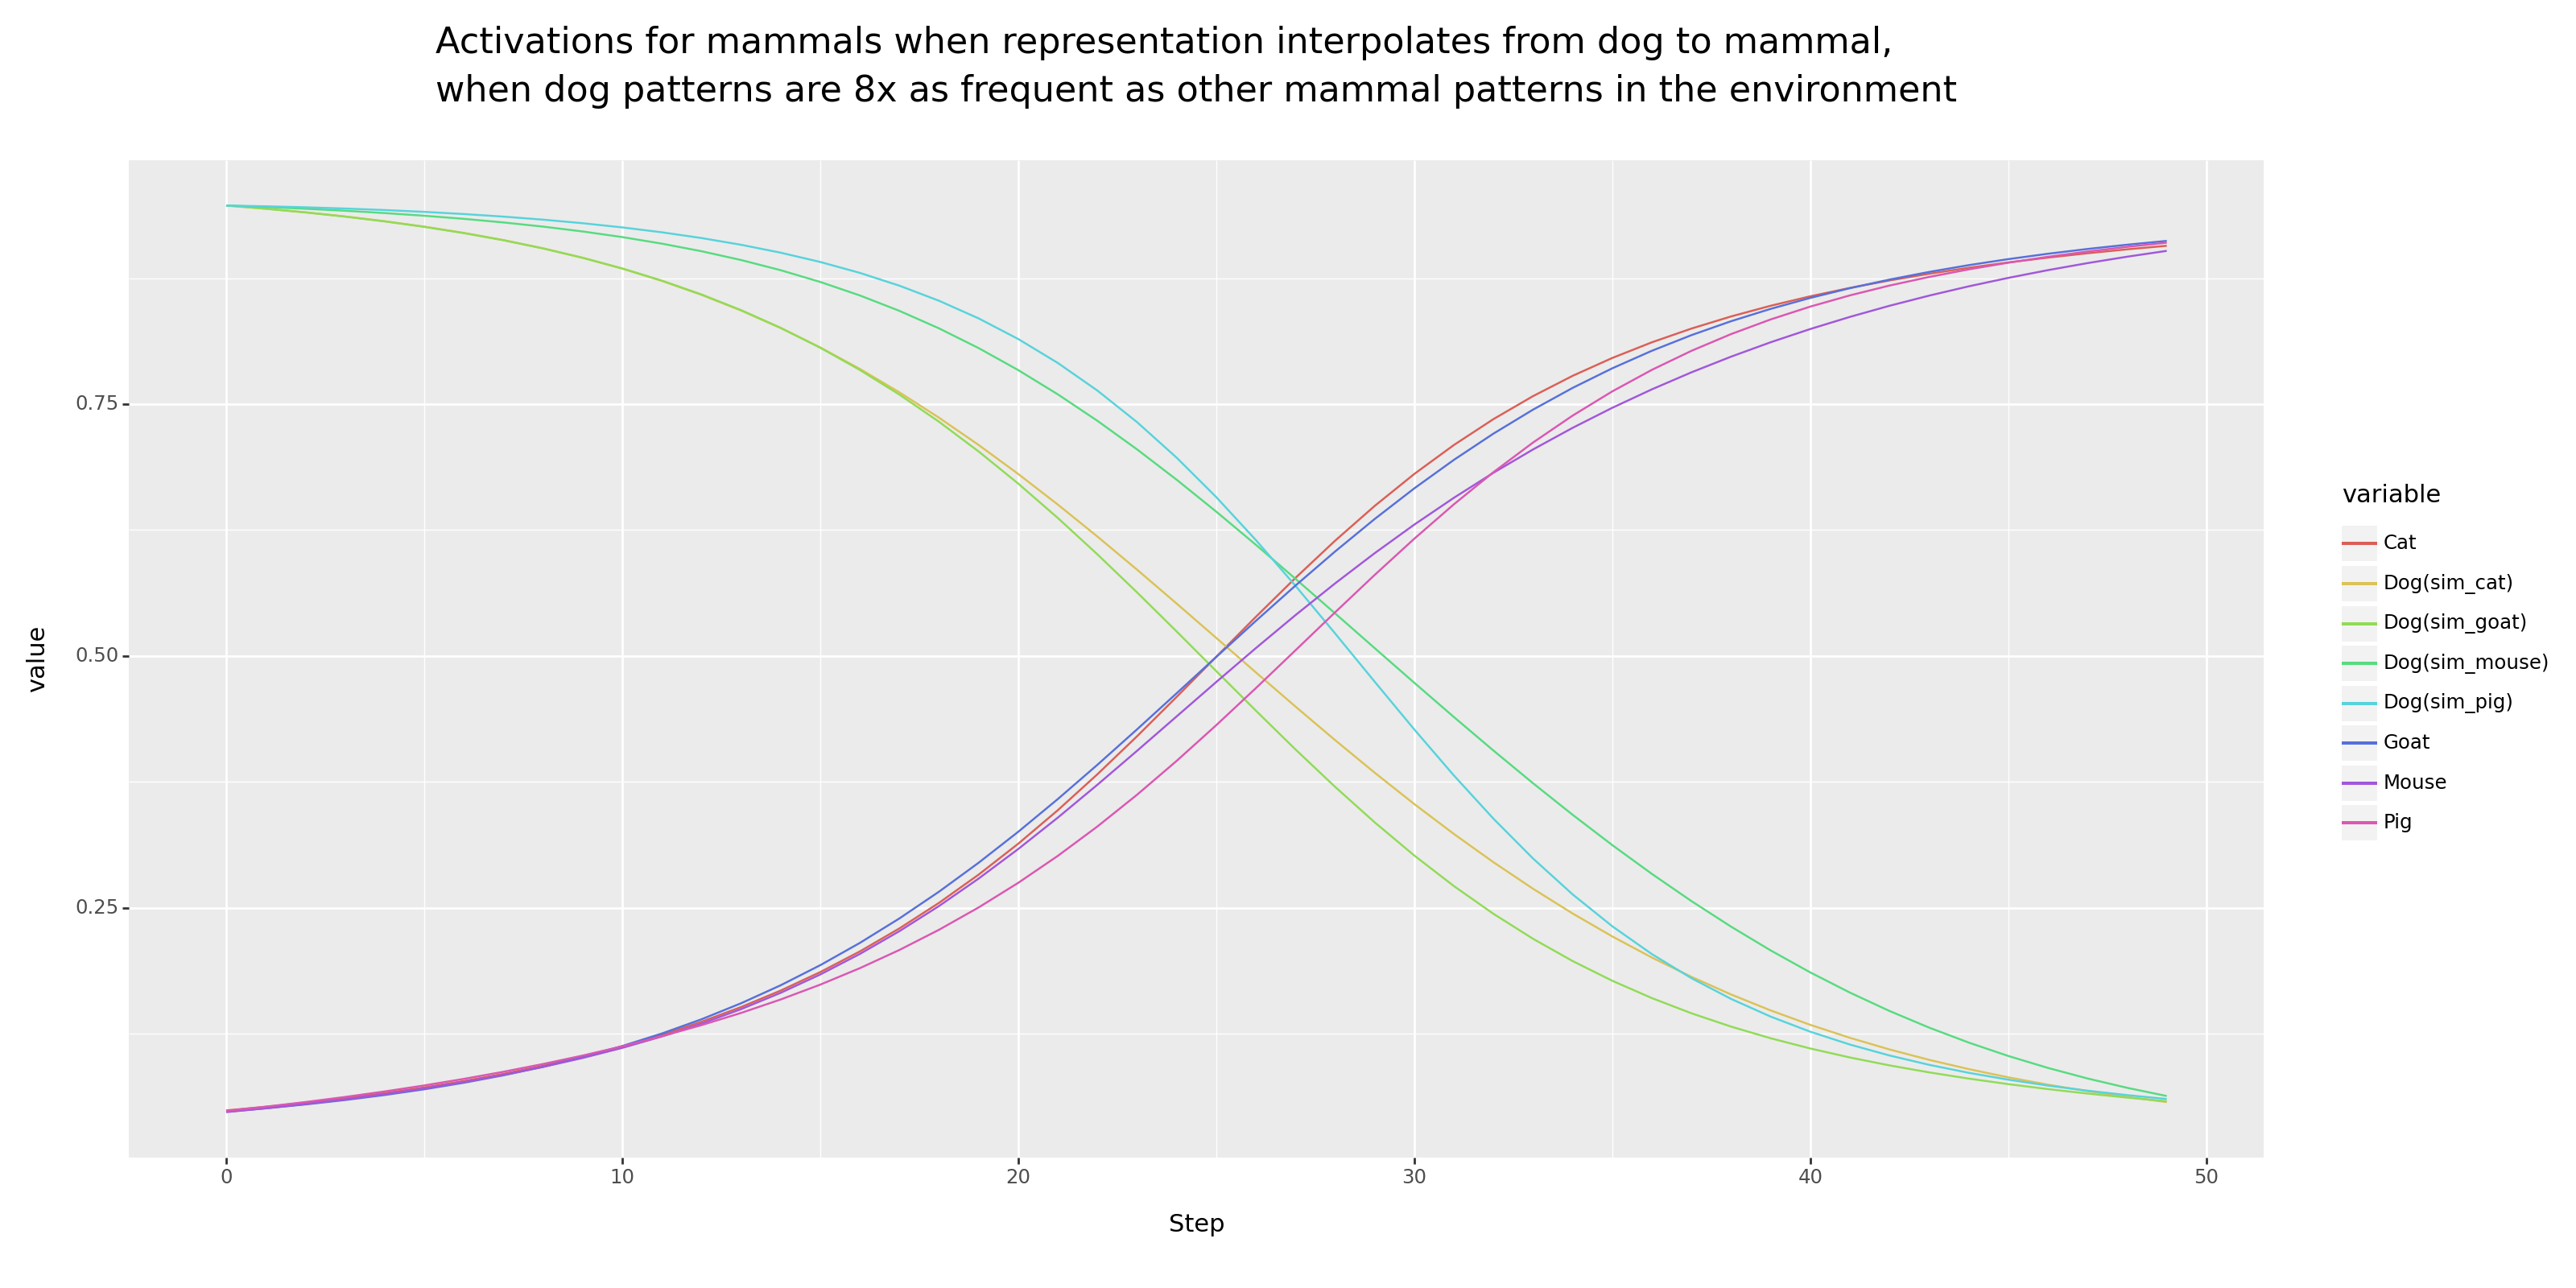

<Figure Size: (1600 x 800)>

In [146]:
sim_interpolate_reps_dogs_8x_diagram = (ggplot(sim_interpolate_reps_dogs_8x, mapping=aes(x="Step", y='value', color='variable'))+
                                        geom_line()+
                                        labs(title = "Activations for mammals when representation interpolates from dog to mammal,\nwhen dog patterns are 8x as frequent as other mammal patterns in the environment")+
                                        theme(figure_size=(16,8), plot_title=element_text(hjust=0.5, size="16", lineheight=1.5)))
sim_interpolate_reps_dogs_8x_diagram